#### [lab 1 parser](https://github.com/itmo-ml-lab-ML-course/parser-misirlouuu/)

In [1]:
import math
import warnings

from prettytable import PrettyTable
import sklearn.metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import stats
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [2]:
mpl.style.use(['ggplot'])

# Вспомогательные функции

In [3]:
def report_performance(
        y: np.ndarray,
        predictions: np.ndarray,
        title: str) -> None:
    report = PrettyTable()
    report.title = title
    report.field_names = ['MSE', 'MAE', 'RMSE', 'MAPE', 'R2']

    # r2 = grid_search.score(x, y)
    r2 = r2_score(y, predictions)
    mse = mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    rmse = math.sqrt(mean_squared_error(y, predictions))
    mape = mean_absolute_percentage_error(y, predictions)

    report.add_row([mse, mae, rmse, mape, r2])

    print(report)

In [4]:
def mape(predictions: np.ndarray, y: np.ndarray) -> np.ndarray:
    # mean_absolute_percentage_error with clipping huge values
    err = np.array(abs((predictions - y) / y))
    err[err > 20] = 20 # clip 2000% error
    return err

In [5]:
def plot_errors(predictions: np.ndarray, y: np.ndarray, data: str) -> None:
    errors = mape(predictions, y)
    plt.hist(errors, bins=100)
    plt.title(f'распределение размера ошибок на {data}')
    plt.xlabel('MAPE')
    plt.ylabel('items count')
    print(f'ошибка на {data}:', errors.mean())

# Чтение и анализ данных

In [6]:
df = pd.read_csv("cian flats.csv")
df.head()

id       price  room          district             subway  \
0  284328061  17346553.0     1       Центральный  Площадь Восстания   
1  282959701   7500000.0     1  Василеостровский   Василеостровская   
2  294531289  23931708.0     1    Адмиралтейский         Балтийская   
3  284780590   8051980.0     1  Василеостровский         Спортивная   
4  262571736  48700000.0     2     Петроградский         Чкаловская   

  subway distance (min)  square footage  livable space  kitchen space  floor  \
0                    13            37.6           24.2            NaN      3   
1                    18            26.1           22.3            NaN      2   
2                     9            53.5           16.5           17.6      8   
3                     5            23.7           20.0            NaN      4   
4                    11            78.4           31.6           17.7      6   

   number of floors  construction year    parking apartment type  house type  \
0                 9             2025.0  Подземная    Новостройка  Монолитный   
1                10                NaN  Подземная       Вторичка  Монолитный   
2                 8             2023.0  Подземная    Новостройка  Монолитный   
3                 4                NaN        NaN       Вторичка   Кирпичный   
4                 9             2022.0  Подземная    Новостройка  Монолитный   

      renovation  bathroom  balcony  elevator  
0            NaN       NaN      NaN       9.0  
1  Косметический       1.0      NaN       NaN  
2            NaN       NaN      NaN       NaN  
3   Дизайнерский       1.0      NaN       NaN  
4            NaN       NaN      NaN       NaN

In [7]:
df.shape

(1358, 19)

In [8]:
df.describe().transpose()

count          mean           std          min  \
id                 1358.0  2.897208e+08  7.120927e+06  164961353.0   
price              1358.0  2.129555e+07  4.244442e+07    1550000.0   
room               1358.0  1.814433e+00  9.852400e-01          0.0   
square footage     1358.0  6.220177e+01  5.743113e+01         11.0   
livable space      1246.0  3.166485e+01  3.088103e+01          4.0   
kitchen space      1138.0  1.445870e+01  1.151600e+01          1.0   
floor              1358.0  5.867452e+00  4.979852e+00          1.0   
number of floors   1358.0  1.194256e+01  6.578449e+00          2.0   
construction year  1228.0  2.006126e+03  3.365348e+01       1756.0   
bathroom           1004.0  1.203187e+00  5.437489e-01          1.0   
balcony             715.0  1.068531e+00  2.689380e-01          1.0   
elevator            821.0  2.482339e+00  2.888369e+00          1.0   

                            25%           50%           75%          max  
id                 2.878237e+08  2.923174e+08  2.939325e+08  294831699.0  
price              7.000000e+06  1.006751e+07  1.614539e+07  465000000.0  
room               1.000000e+00  1.000000e+00  2.000000e+00          5.0  
square footage     3.348500e+01  4.691500e+01  6.801500e+01        904.0  
livable space      1.520000e+01  2.280000e+01  3.777500e+01        528.0  
kitchen space      8.100000e+00  1.180000e+01  1.690000e+01        145.0  
floor              2.000000e+00  4.000000e+00  8.000000e+00         26.0  
number of floors   7.000000e+00  1.000000e+01  1.600000e+01         36.0  
construction year  2.007000e+03  2.021000e+03  2.023000e+03       2026.0  
bathroom           1.000000e+00  1.000000e+00  1.000000e+00          6.0  
balcony            1.000000e+00  1.000000e+00  1.000000e+00          3.0  
elevator           1.000000e+00  2.000000e+00  2.000000e+00         30.0

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1358 entries, 0 to 1357
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1358 non-null   int64  
 1   price                  1358 non-null   float64
 2   room                   1358 non-null   int64  
 3   district               1358 non-null   object 
 4   subway                 1260 non-null   object 
 5   subway distance (min)  1250 non-null   object 
 6   square footage         1358 non-null   float64
 7   livable space          1246 non-null   float64
 8   kitchen space          1138 non-null   float64
 9   floor                  1358 non-null   int64  
 10  number of floors       1358 non-null   int64  
 11  construction year      1228 non-null   float64
 12  parking                769 non-null    object 
 13  apartment type         1358 non-null   object 
 14  house type             1190 non-null   object 
 15  reno

In [10]:
df.isnull().sum()

id                         0
price                      0
room                       0
district                   0
subway                    98
subway distance (min)    108
square footage             0
livable space            112
kitchen space            220
floor                      0
number of floors           0
construction year        130
parking                  589
apartment type             0
house type               168
renovation               531
bathroom                 354
balcony                  643
elevator                 537
dtype: int64

<Axes: >

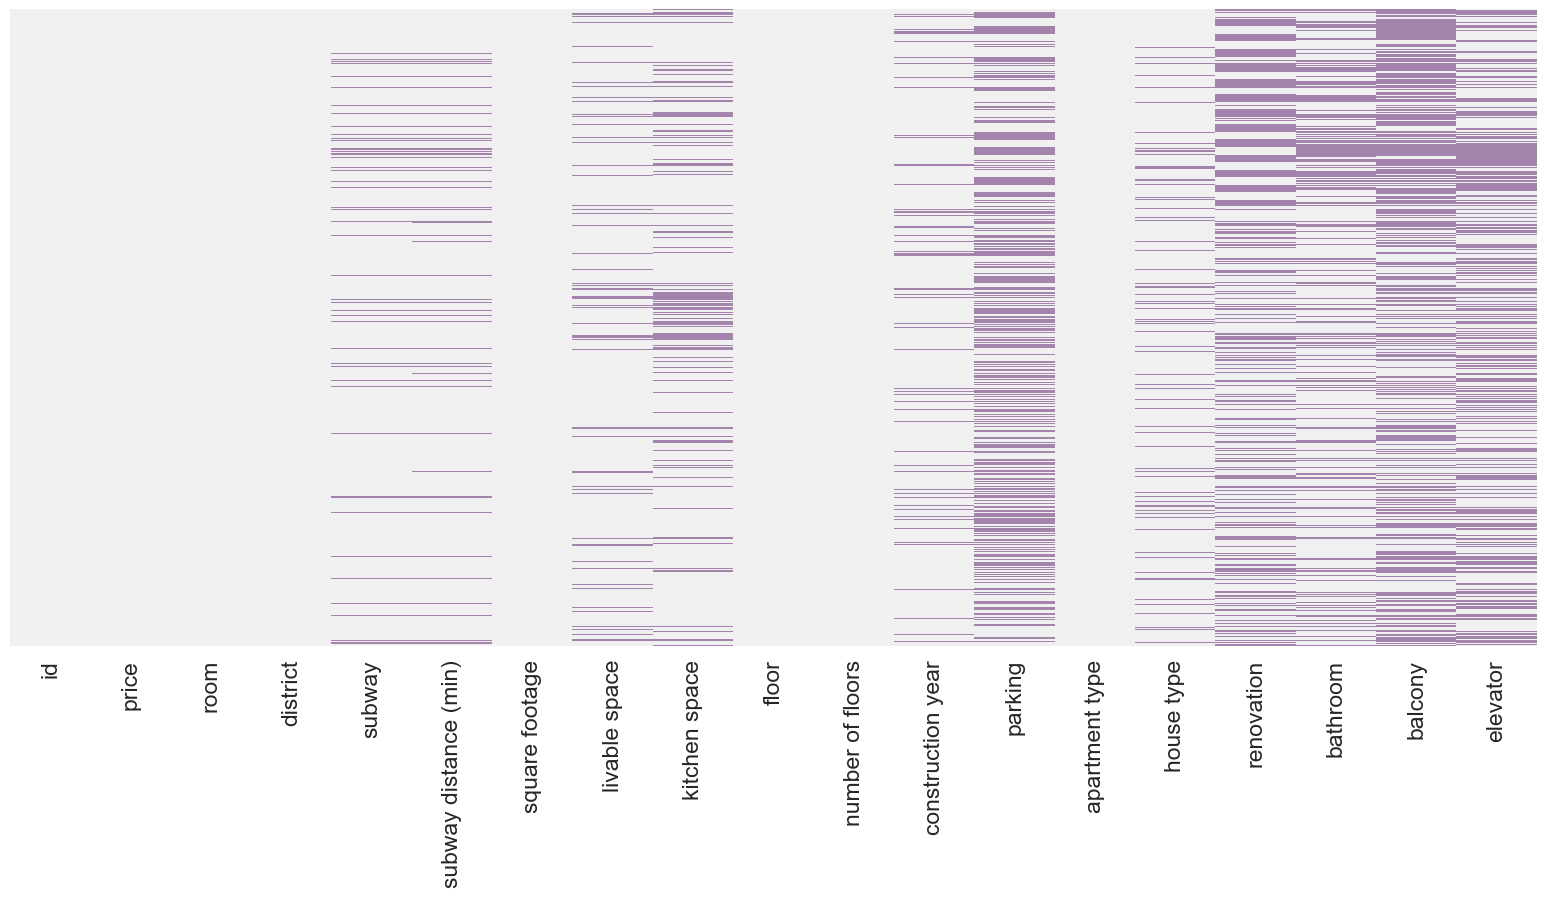

In [11]:
sns.set(font_scale=1.5, rc={'figure.figsize':(19.7,8.27)})
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap=sns.light_palette('xkcd:heather', as_cmap=True))

# Предобработка данных

## Очистка данных

In [12]:
df.head

<bound method NDFrame.head of              id       price  room          district             subway  \
0     284328061  17346553.0     1       Центральный  Площадь Восстания   
1     282959701   7500000.0     1  Василеостровский   Василеостровская   
2     294531289  23931708.0     1    Адмиралтейский         Балтийская   
3     284780590   8051980.0     1  Василеостровский         Спортивная   
4     262571736  48700000.0     2     Петроградский         Чкаловская   
...         ...         ...   ...               ...                ...   
1353  292580271  14800000.0     2        Выборгский             Лесная   
1354  293280176  14846500.0     2        Выборгский             Лесная   
1355  280115575  14933280.0     3       Калининский         Выборгская   
1356  291916086  14900000.0     2       Центральный       Чернышевская   
1357  293320129  14855008.0     1        Московский         Московская   

     subway distance (min)  square footage  livable space  kitchen space  \
0    

In [13]:
df['house type'] = df['house type'].str.replace(',','')

In [14]:
df['renovation'].fillna('Без', inplace=True)

In [15]:
df['parking'].fillna(0, inplace=True)
df['parking'] = np.where(df['parking'] != 0, 1, 0)

In [16]:
df.loc[:, 'subway distance (min)'].replace('откроется', None, inplace=True)
df['subway distance (min)'] = df['subway distance (min)'].astype(float)

In [17]:
df['bathroom'].fillna(1, inplace=True)
df['bathroom'] = df['bathroom'].astype(int)

In [18]:
df['elevator'].fillna(0, inplace=True)
df['elevator'] = df['elevator'].astype(int)

In [19]:
df['balcony'].fillna(0, inplace=True)
df['balcony'] = df['balcony'].astype(int)

In [20]:
df.dropna(inplace=True)
df.head

<bound method NDFrame.head of              id       price  room        district                    subway  \
2     294531289  23931708.0     1  Адмиралтейский                Балтийская   
4     262571736  48700000.0     2   Петроградский                Чкаловская   
5     292246812  36000000.0     3  Адмиралтейский  Технологический институт   
6     250578804  70726917.0     3   Петроградский                Чкаловская   
12    294696187   9278465.0     1     Фрунзенский                Волковская   
...         ...         ...   ...             ...                       ...   
1345  291677048  14569788.0     2      Московский         Московские ворота   
1351  285017876  14726920.0     1         Невский              Елизаровская   
1353  292580271  14800000.0     2      Выборгский                    Лесная   
1354  293280176  14846500.0     2      Выборгский                    Лесная   
1355  280115575  14933280.0     3     Калининский                Выборгская   

      subway distance

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 813 entries, 2 to 1355
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     813 non-null    int64  
 1   price                  813 non-null    float64
 2   room                   813 non-null    int64  
 3   district               813 non-null    object 
 4   subway                 813 non-null    object 
 5   subway distance (min)  813 non-null    float64
 6   square footage         813 non-null    float64
 7   livable space          813 non-null    float64
 8   kitchen space          813 non-null    float64
 9   floor                  813 non-null    int64  
 10  number of floors       813 non-null    int64  
 11  construction year      813 non-null    float64
 12  parking                813 non-null    int64  
 13  apartment type         813 non-null    object 
 14  house type             813 non-null    object 
 15  renovation

In [22]:
# поиск дубликатов
df.loc[df.duplicated()]

Empty DataFrame
Columns: [id, price, room, district, subway, subway distance (min), square footage, livable space, kitchen space, floor, number of floors, construction year, parking, apartment type, house type, renovation, bathroom, balcony, elevator]
Index: []

In [23]:
df['construction year'] = df['construction year'].astype(int)

## Добавление нового признака

Можно предположить, что фактор, расположена ли квартира на первом этаже, может влиять на итоговую цену. Действительно, из-за низкого уровня безопасности, а также большого количества шума с улицы, покупатели не стремятся приобретать квартиры на данном этаже.

In [24]:
df['first floor'] = np.where(df['floor'] == 1, 1, 0)

In [25]:
df[['floor', 'number of floors', 'first floor']]

floor  number of floors  first floor
2         8                 8            0
4         6                 9            0
5         5                 6            0
6         6                 7            0
12       14                14            0
...     ...               ...          ...
1345      1                 8            1
1351      1                18            1
1353      3                12            0
1354      1                12            1
1355      1                 7            1

[813 rows x 3 columns]

In [26]:
df.columns

Index(['id', 'price', 'room', 'district', 'subway', 'subway distance (min)',
       'square footage', 'livable space', 'kitchen space', 'floor',
       'number of floors', 'construction year', 'parking', 'apartment type',
       'house type', 'renovation', 'bathroom', 'balcony', 'elevator',
       'first floor'],
      dtype='object')

In [27]:
df['price'] = df['price'].apply(lambda x: x / 1000000) # для корректного отображения цены в миллионах

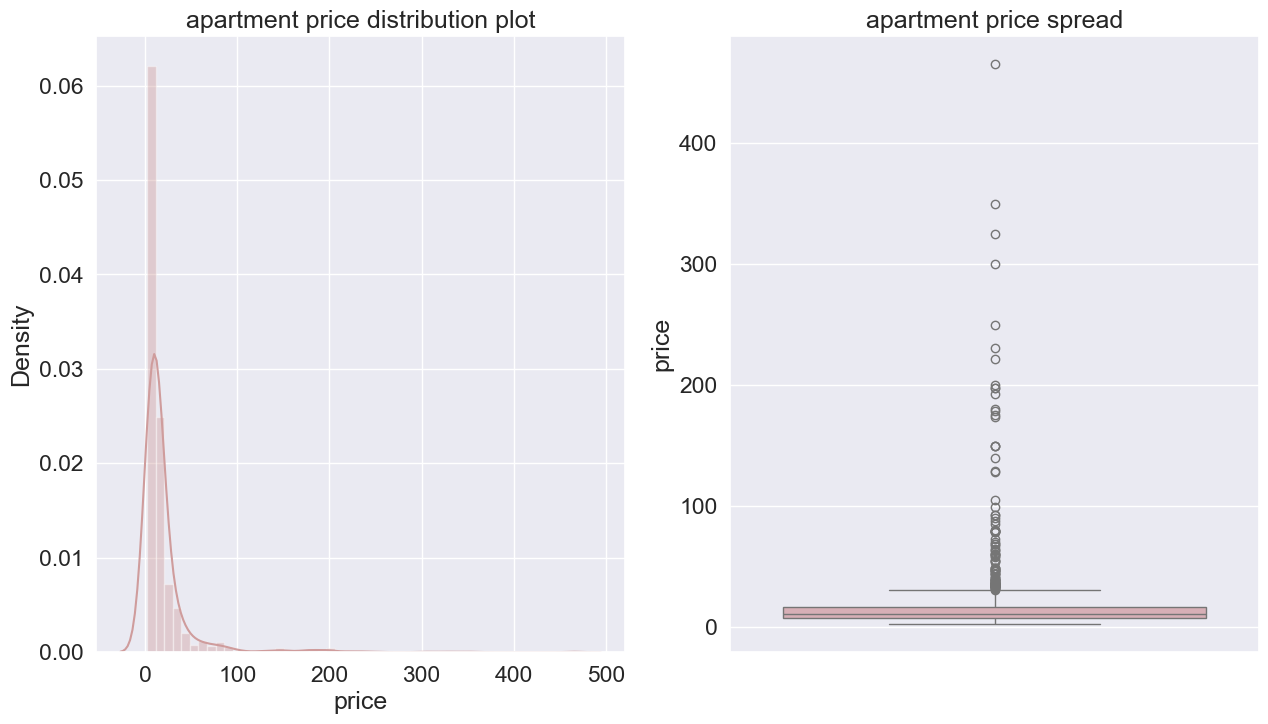

In [28]:
plt.figure(figsize=(15, 8))

plt.subplot(1,2,1)
plt.title('apartment price distribution plot')
sns.distplot(df['price'], color='#cf9c9c')

plt.subplot(1,2,2)
plt.title('apartment price spread')
sns.boxplot(y=df['price'], color='#dda9b2')

plt.show()

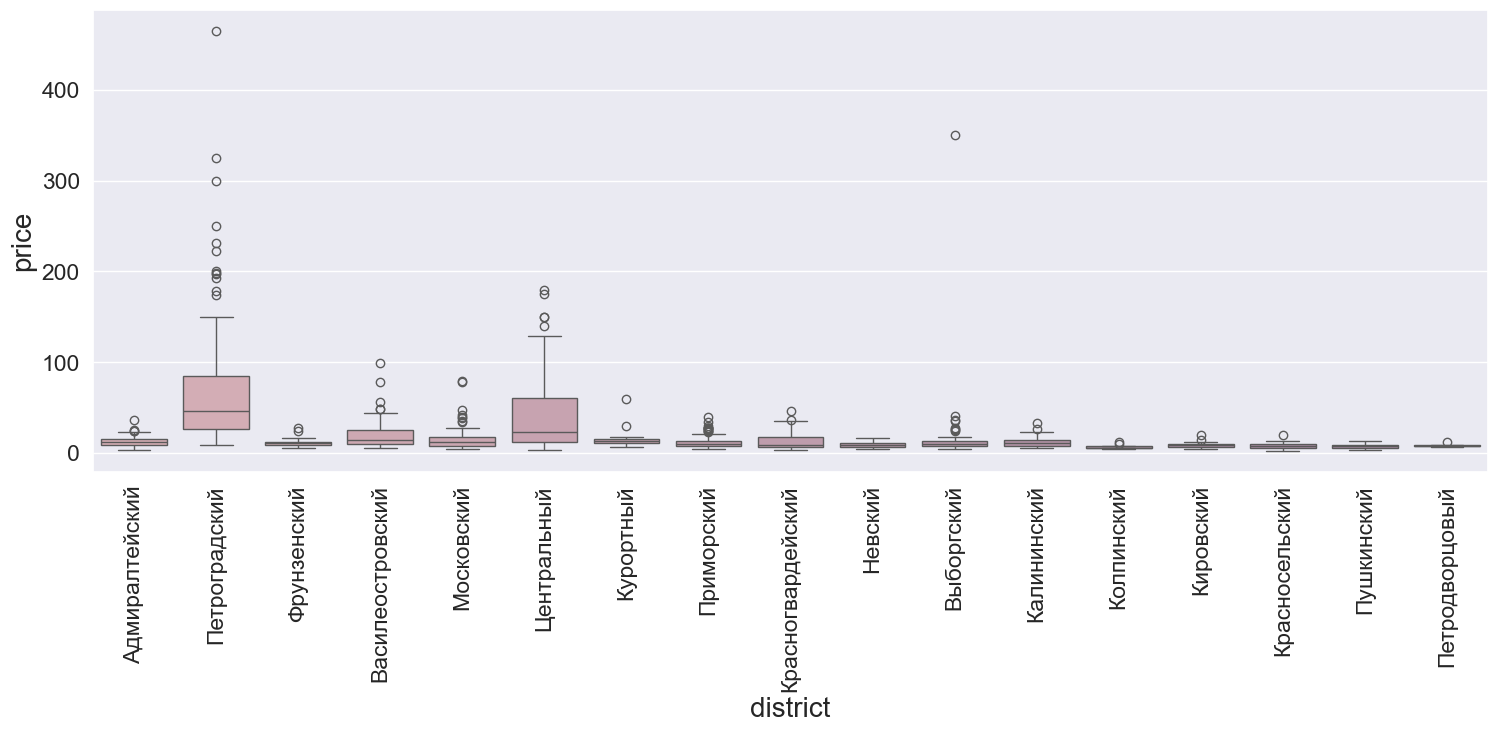

In [29]:
plt.figure(figsize=(18, 6))
chart2 = sns.boxplot(x = df["district"], y = df["price"], palette="blend:#dda9b2,#aa83a6")
chart2.set_xticklabels(chart2.get_xticklabels(), rotation=90)
plt.xlabel("district", size=20)
plt.ylabel("price", size=20)
plt.show();

Распределение цены далеко от нормального, наблюдается очень большое количество выбросов, обусловленное главным образом неоправданно завышенным ценником на жилье в Петроградском районе, в частности на Крестовском острове.

Чтобы удалить выбросы, воспользуемся стандартизированной оценкой z-score, которая показывает, на сколько средних квадратических отклонений значение отличается от среднего. Так как мы знаем, что 99,7 процентов наблюдений лежат в пределах трех СКО от среднего, то можем предположить, что выбросами будут оставшиеся 0,3 процента.

## Удаление выбросов

In [30]:
def remove_outliers(column_name, df_in):
    print(f"length before removing {column_name} outlier:",  len(df_in))
    df_in[f'{column_name}_zscore'] = np.abs(stats.zscore(df_in[f'{column_name}']))
    df_clean = df_in[df_in[f'{column_name}_zscore'] < 3]
    print(f"length after removing {column_name} outlier:",  len(df_clean))
    return df_clean

In [31]:
df = remove_outliers('price', df)

length before removing price outlier: 813
length after removing price outlier: 794


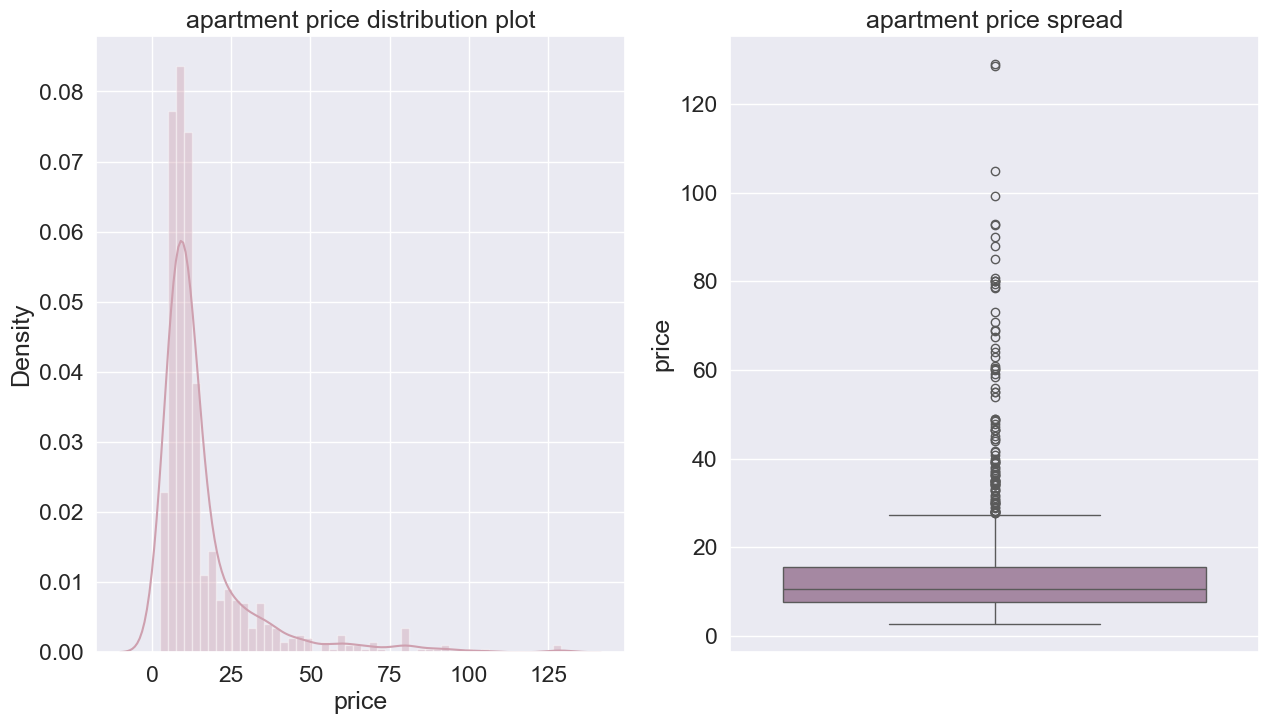

In [32]:
plt.figure(figsize=(15, 8))

plt.subplot(1,2,1)
plt.title('apartment price distribution plot')
sns.distplot(df['price'], color='#cea0af')

plt.subplot(1,2,2)
plt.title('apartment price spread')
sns.boxplot(y=df['price'], color='#aa83a6')

plt.show()

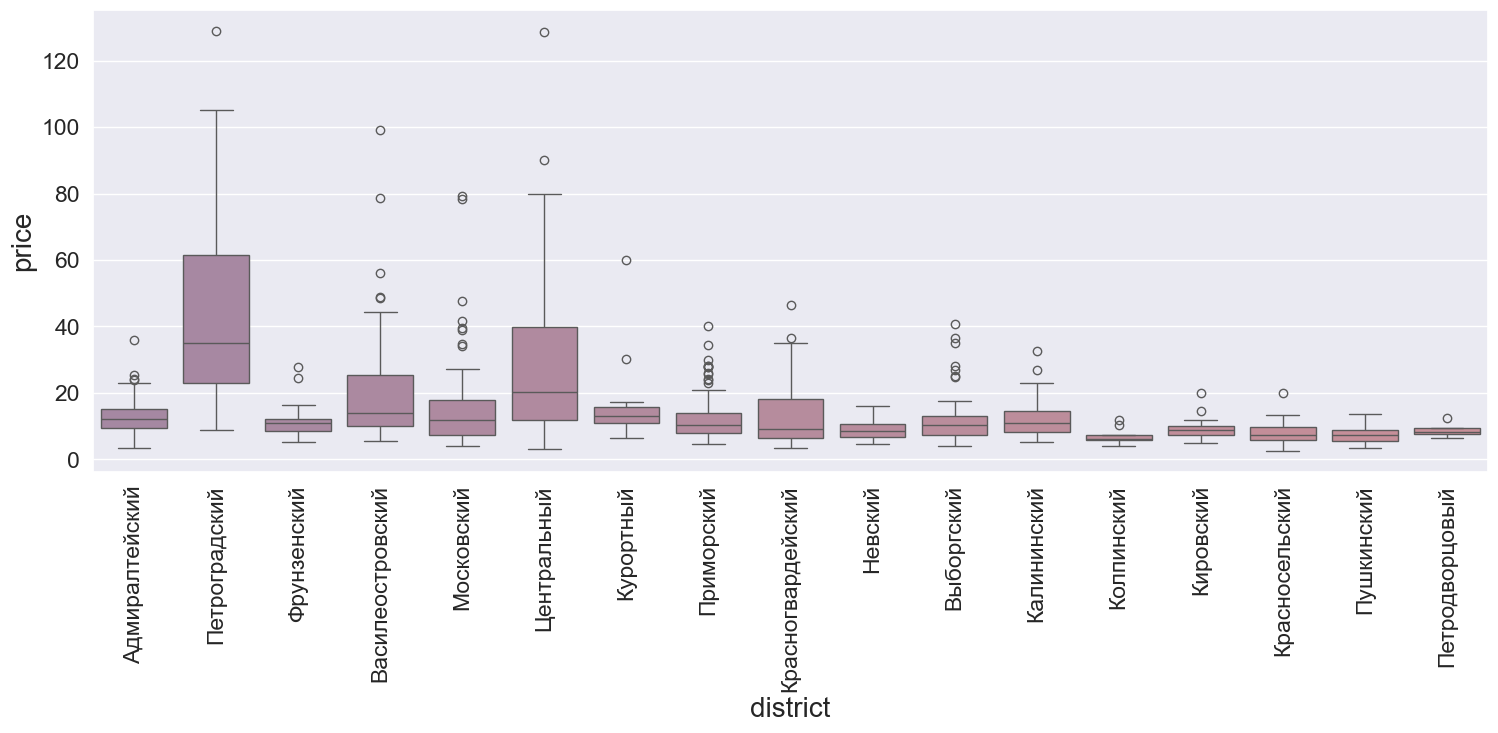

In [33]:
plt.figure(figsize=(18, 6))
chart2 = sns.boxplot(x = df["district"], y = df["price"], palette="blend:#aa83a6,#d08692")
chart2.set_xticklabels(chart2.get_xticklabels(), rotation=90)
plt.xlabel("district", size=20)
plt.ylabel("price", size=20)
plt.show();

In [34]:
df['price'].describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1])

count    794.000000
mean      15.783699
std       15.926508
min        2.600000
25%        7.600597
50%       10.600000
75%       15.471754
85%       24.500761
90%       32.799660
100%     129.000000
max      129.000000
Name: price, dtype: float64

In [35]:
df.head

<bound method NDFrame.head of              id      price  room        district                    subway  \
2     294531289  23.931708     1  Адмиралтейский                Балтийская   
4     262571736  48.700000     2   Петроградский                Чкаловская   
5     292246812  36.000000     3  Адмиралтейский  Технологический институт   
6     250578804  70.726917     3   Петроградский                Чкаловская   
12    294696187   9.278465     1     Фрунзенский                Волковская   
...         ...        ...   ...             ...                       ...   
1345  291677048  14.569788     2      Московский         Московские ворота   
1351  285017876  14.726920     1         Невский              Елизаровская   
1353  292580271  14.800000     2      Выборгский                    Лесная   
1354  293280176  14.846500     2      Выборгский                    Лесная   
1355  280115575  14.933280     3     Калининский                Выборгская   

      subway distance (min)  squa

## Исследование категориальных признаков

### Район

[Text(0.5, 1.0, 'district histogram')]

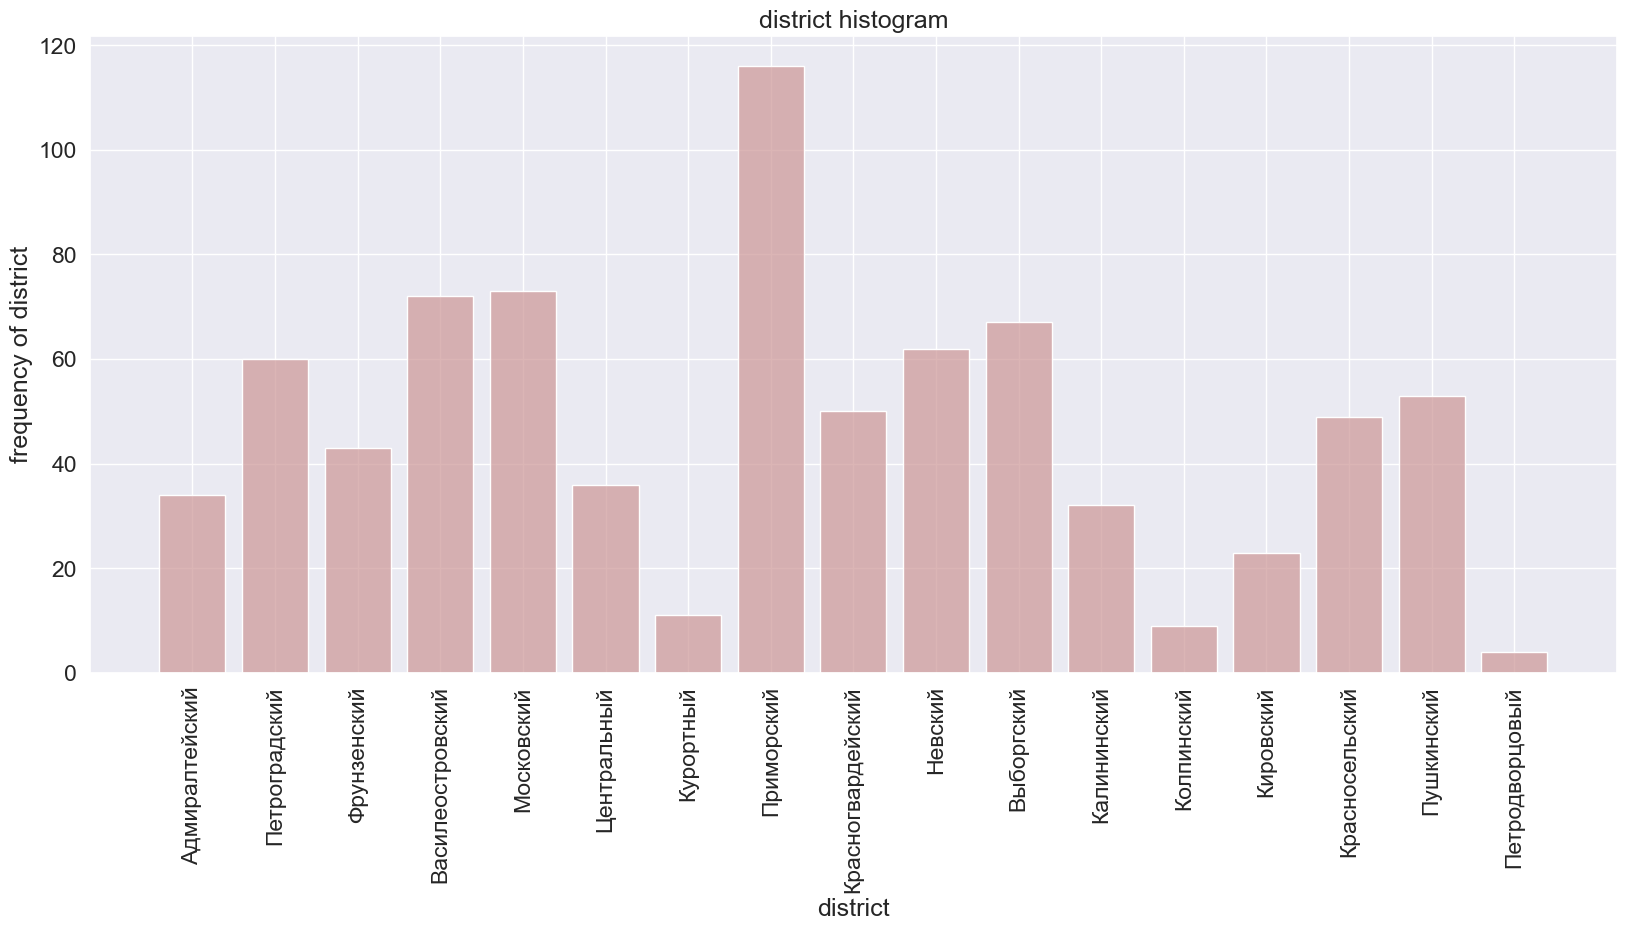

In [36]:
ax = sns.histplot(df['district'], shrink=0.8, color="#cf9c9c")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(xlabel='district', ylabel='frequency of district')
ax.set(title='district histogram')

По гистограмме видно, что чаще всего выставляют на продажу квартиры, расположенные в Приморском районе. Очень мало квартир продаётся в Колпинском и Петродворцовом районе.

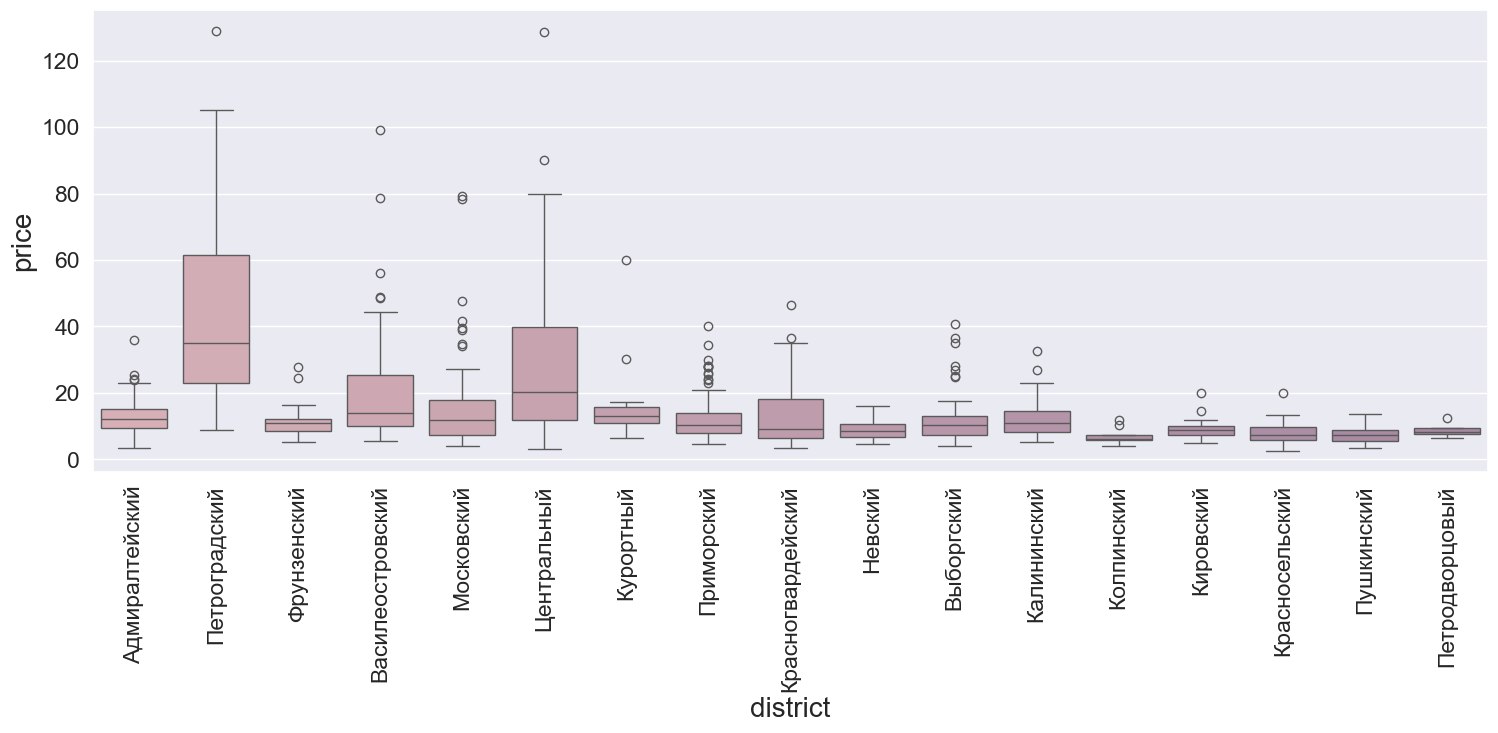

In [37]:
plt.figure(figsize=(18, 6))
chart2 = sns.boxplot(x = df["district"], y = df["price"], palette="blend:#dda9b2,#aa83a6")
chart2.set_xticklabels(chart2.get_xticklabels(), rotation=90)
plt.xlabel("district", size=20)
plt.ylabel("price", size=20)
plt.show();

Боксплоты наглядно демонстрируют, что наибольший разброс цены наблюдается в Петроградском районе. Несмотря на то, что была произведена очистка от выбросов, по сути были удалены лишь выбросы в одном конкретном районе.

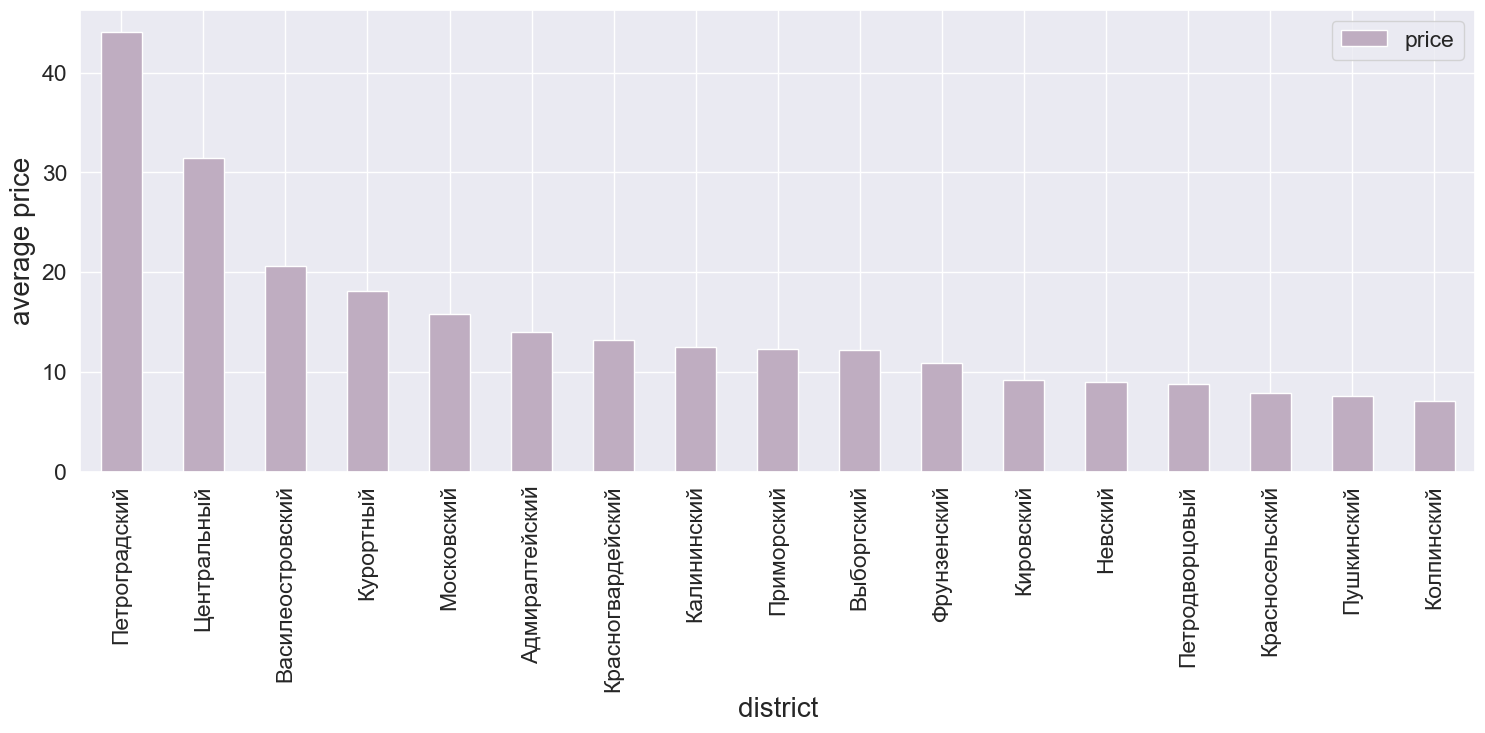

In [38]:
copy = pd.DataFrame(df.groupby(['district'])['price'].mean().sort_values(ascending = False))
copy.plot.bar(figsize=(18,6), color="#bfadc1")
plt.xlabel("district", size=20)
plt.ylabel("average price", size=20)
plt.show()

Средняя цена на недвижимость, по сравнению с другими района, является неоправданно завышенной именно в Петроградском и Центральном районах.

### Станция метро

[Text(0.5, 1.0, 'subway histogram')]

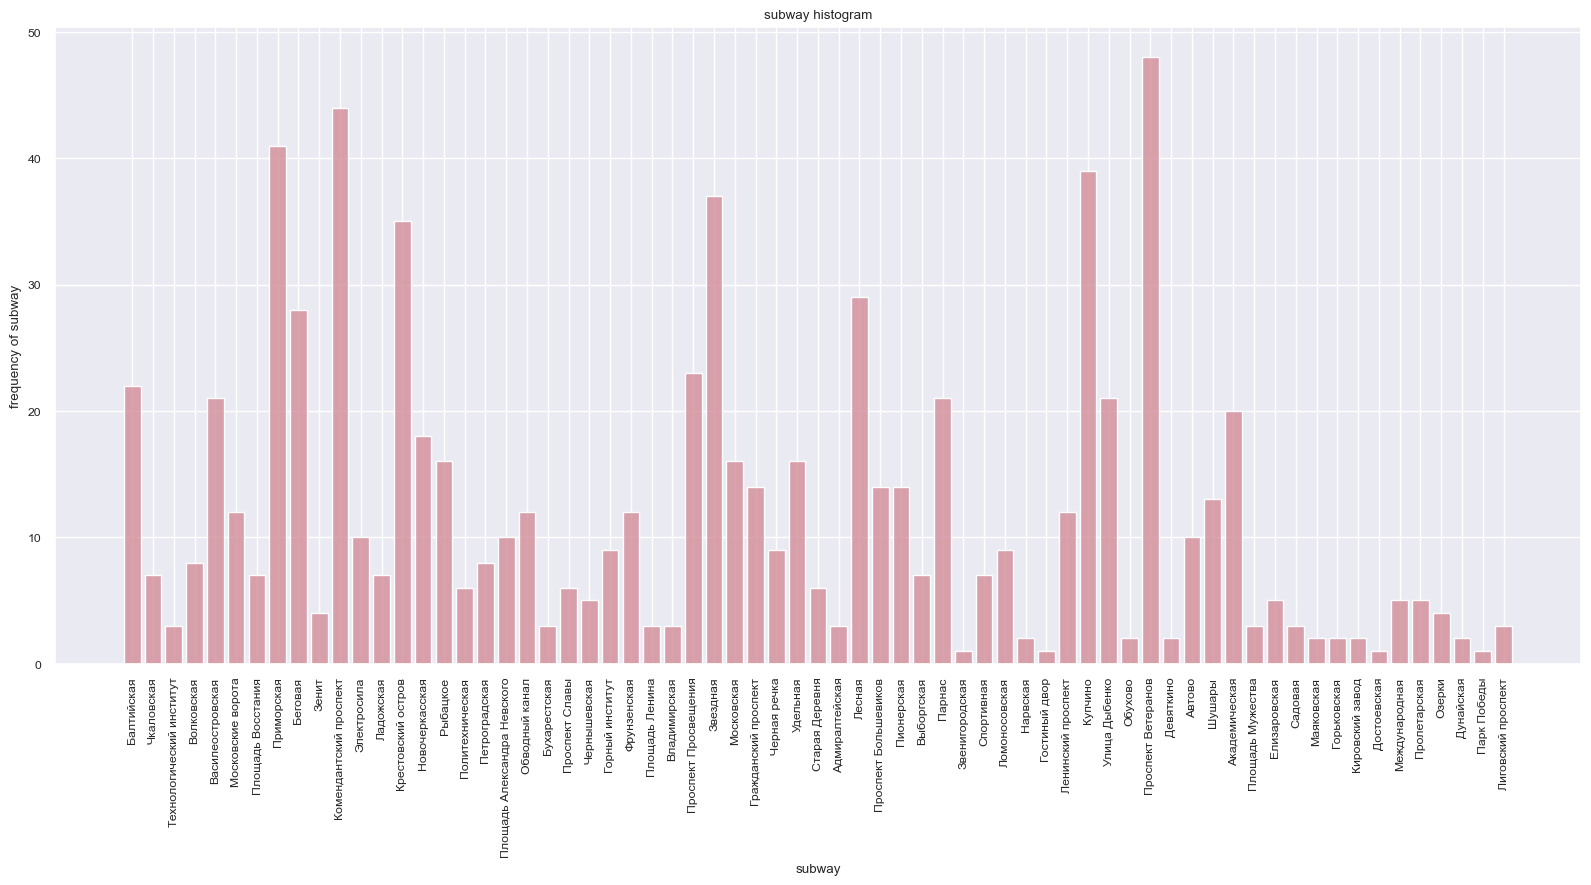

In [39]:
sns.set(font_scale=0.8)
ax = sns.histplot(df['subway'], shrink=0.8, color="#d08692")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(xlabel='subway', ylabel='frequency of subway')
ax.set(title='subway histogram')

Чаще всего представлены объявления о продаже квартир, находящихся рядом со станциями метро Проспект Ветеранов и Комендантский проспект.

In [40]:
sns.set(font_scale=1.2)

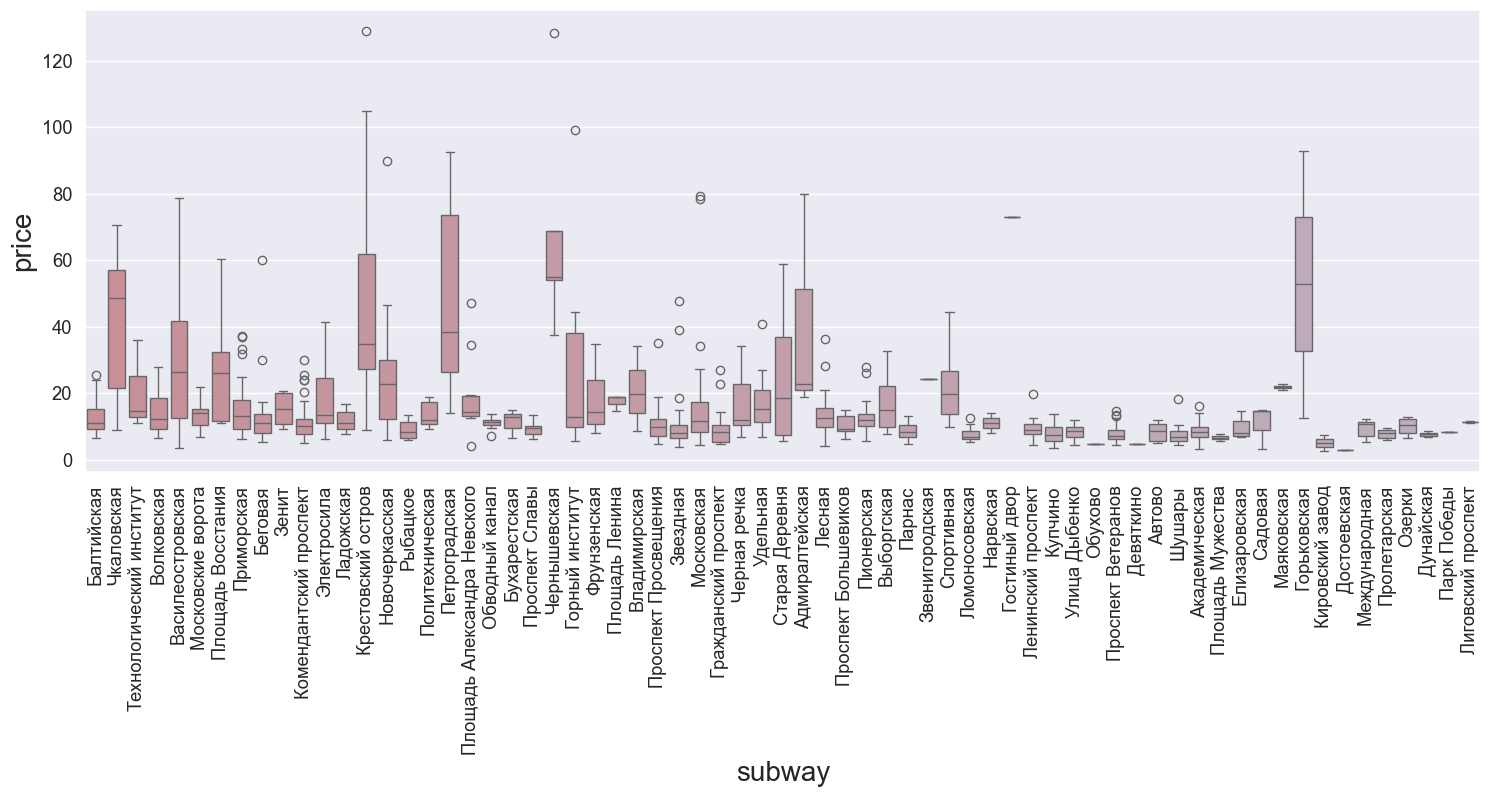

In [41]:
plt.figure(figsize=(18, 6))
chart2 = sns.boxplot(x = df["subway"], y = df["price"], palette="blend:#d08692,#bfadc1")
chart2.set_xticklabels(chart2.get_xticklabels(), rotation=90)
plt.xlabel("subway", size=20)
plt.ylabel("price", size=20)
plt.show();

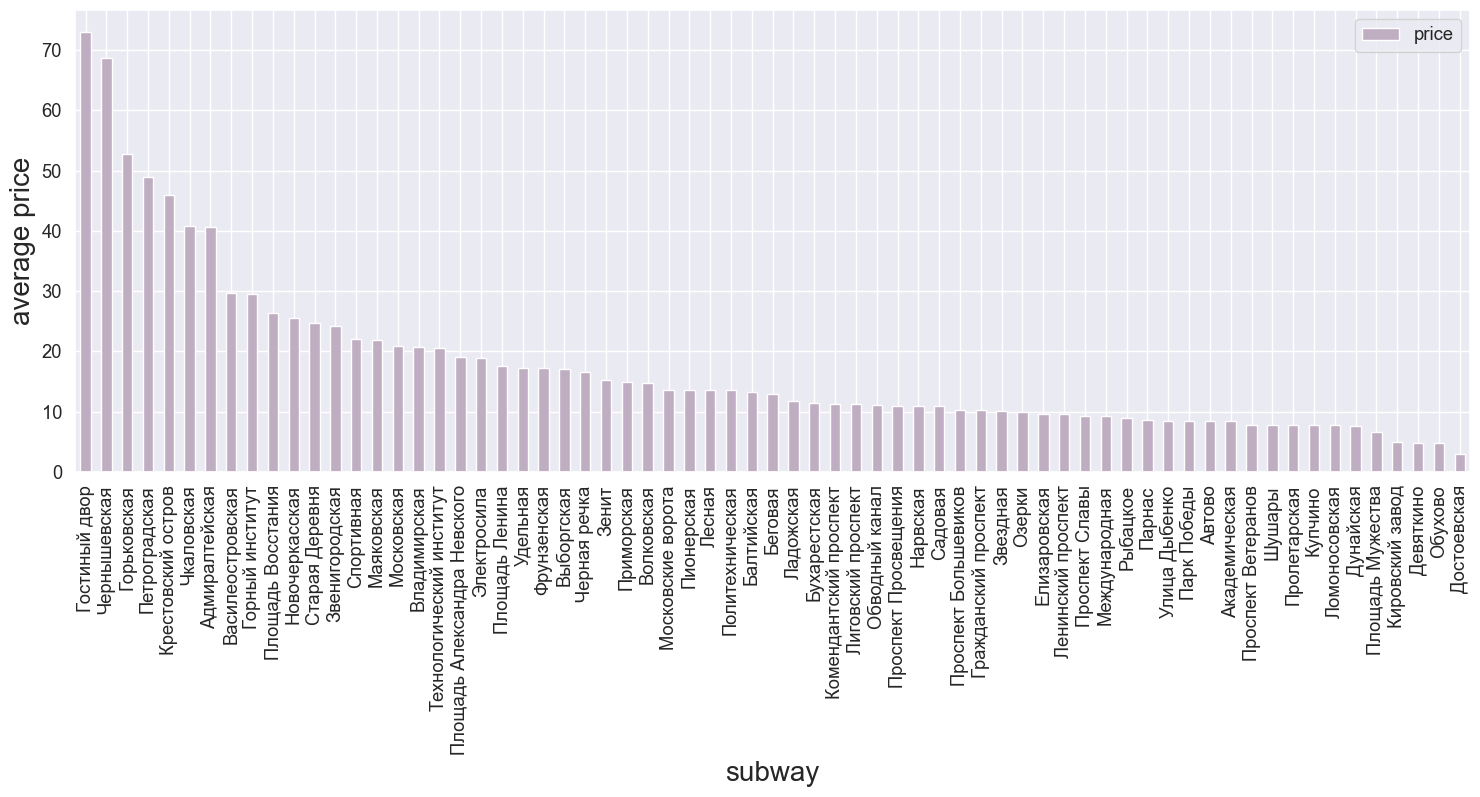

In [42]:
copy = pd.DataFrame(df.groupby(['subway'])['price'].mean().sort_values(ascending = False))
copy.plot.bar(figsize=(18,6), color="#bfadc1")
plt.xlabel("subway", size=20)
plt.ylabel("average price", size=20)
plt.show()

### Тип жилья

In [43]:
sns.set(font_scale=2)
sns.set(rc={'figure.figsize':(9, 5)})

[Text(0.5, 1.0, 'apartment type histogram')]

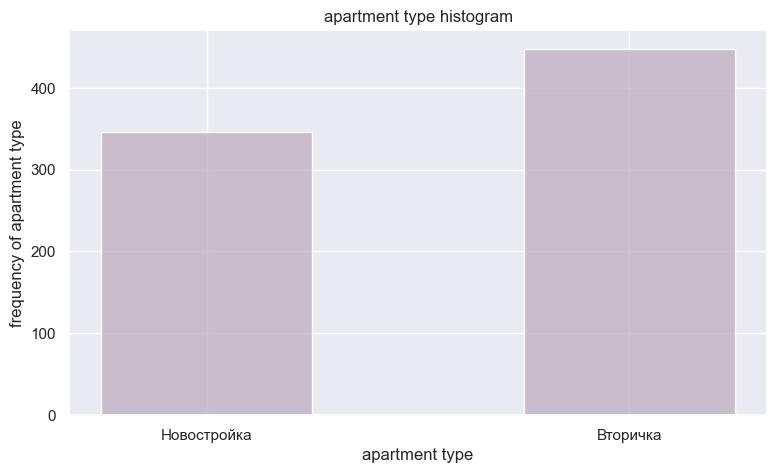

In [44]:
ax = sns.histplot(df['apartment type'], shrink=0.5, color="#bfadc1")
ax.set(xlabel='apartment type', ylabel='frequency of apartment type')
ax.set(title='apartment type histogram')

По гистограммам видно, что обычно на продажу выставляют квартиры из вторичного жилья, нежели чем из новостроек.

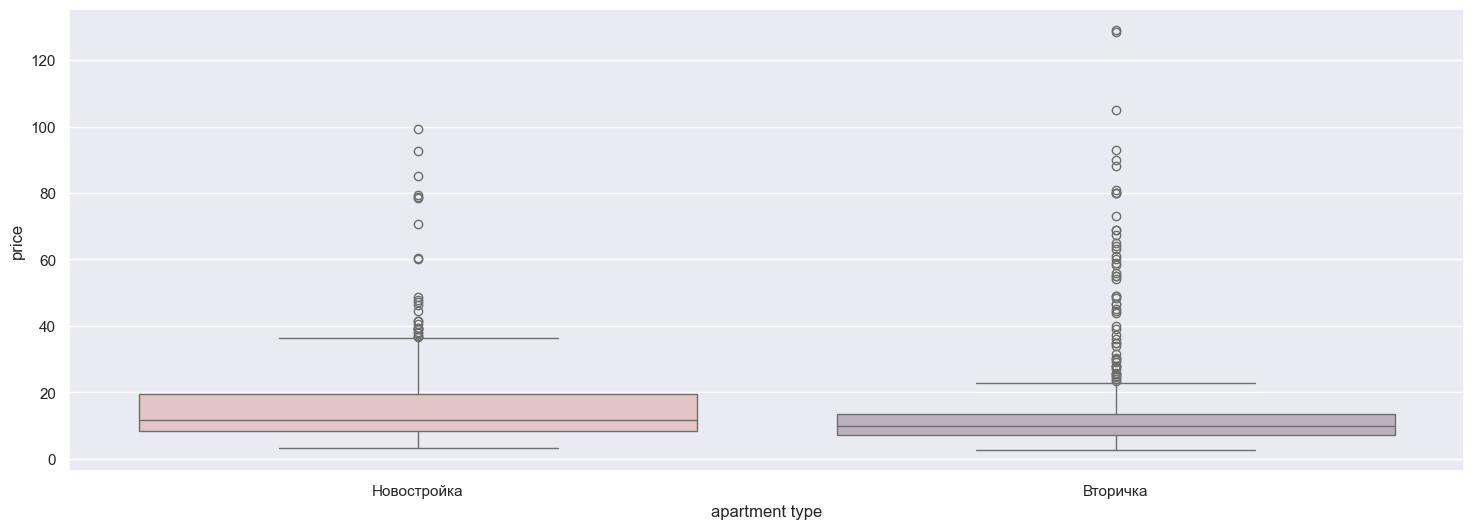

In [45]:
plt.figure(figsize=(18, 6))
chart2 = sns.boxplot(x = df["apartment type"], y = df["price"], palette="blend:#e8c0c0,#bfadc1")
plt.xlabel("apartment type")
plt.ylabel("price")
plt.show();

Разброс цены у квартир из новостроек немного больше, чем у квартир из вторичек. Также имеется большое количество выбросов.

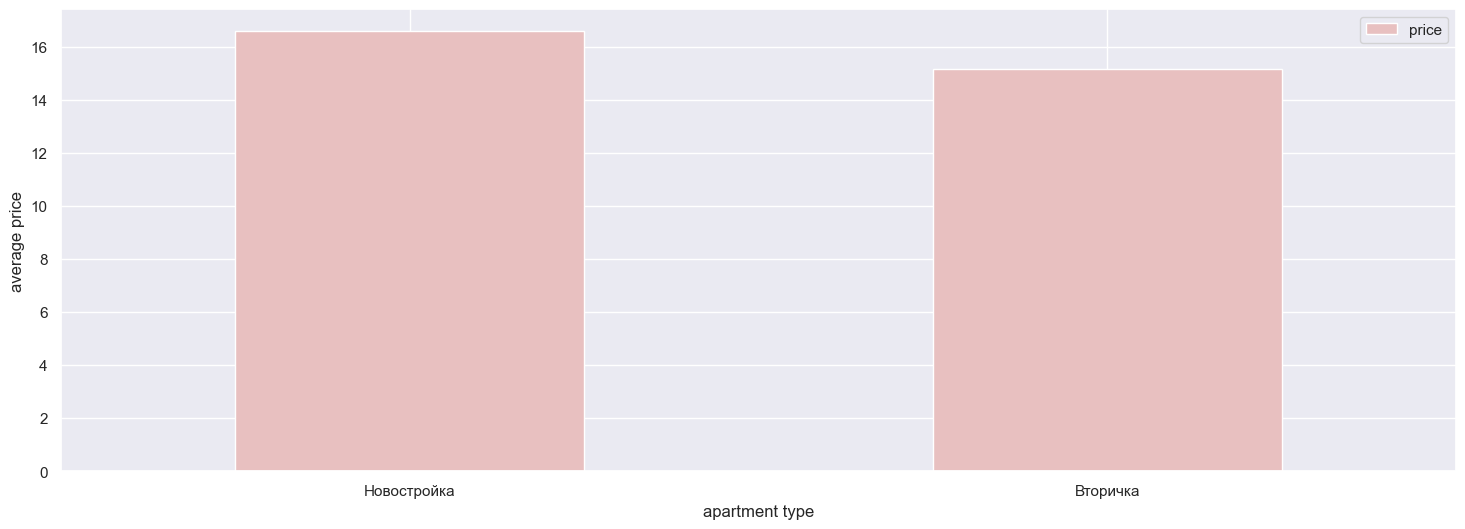

In [46]:
copy = pd.DataFrame(df.groupby(['apartment type'])['price'].mean().sort_values(ascending = False))
copy.plot.bar(figsize=(18,6), color="#e8c0c0", rot=0)
plt.xlabel("apartment type")
plt.ylabel("average price")
plt.show()

Средняя цена на квартиру из новостройки немного выше, чем на квартиру из вторичного жилья. Возможно, этот категориальный признак сыграет роль в дальнейшем формировании цены на квартиру.

### Тип дома

[Text(0.5, 1.0, 'house type histogram')]

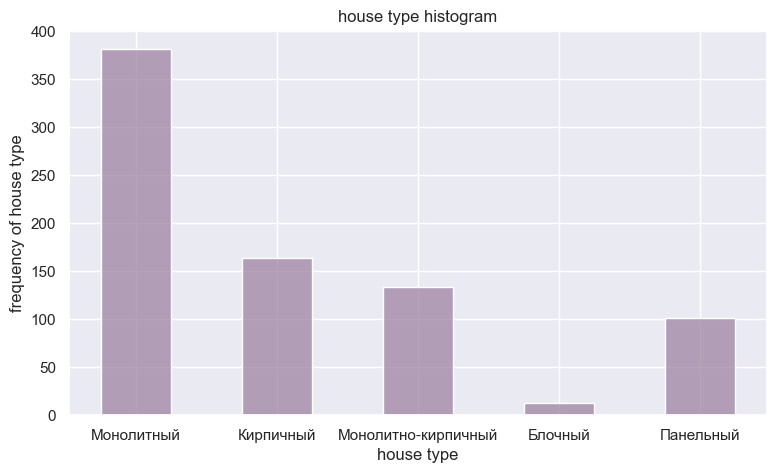

In [47]:
ax = sns.histplot(df['house type'], shrink=0.5, color="#9e84a1")
ax.set(xlabel='house type', ylabel='frequency of house type')
ax.set(title='house type histogram')

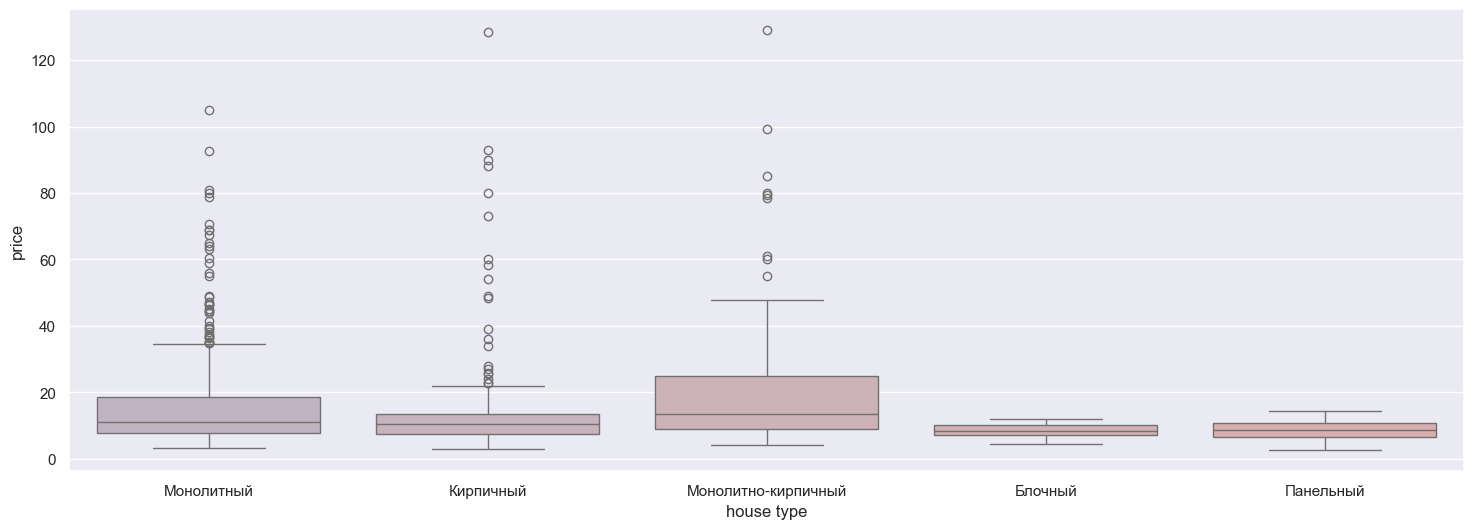

In [48]:
plt.figure(figsize=(18, 6))
chart2 = sns.boxplot(x = df["house type"], y = df["price"], palette="blend:#c3b2c4,#dfa9a8")
plt.xlabel("house type")
plt.ylabel("price")
plt.show();

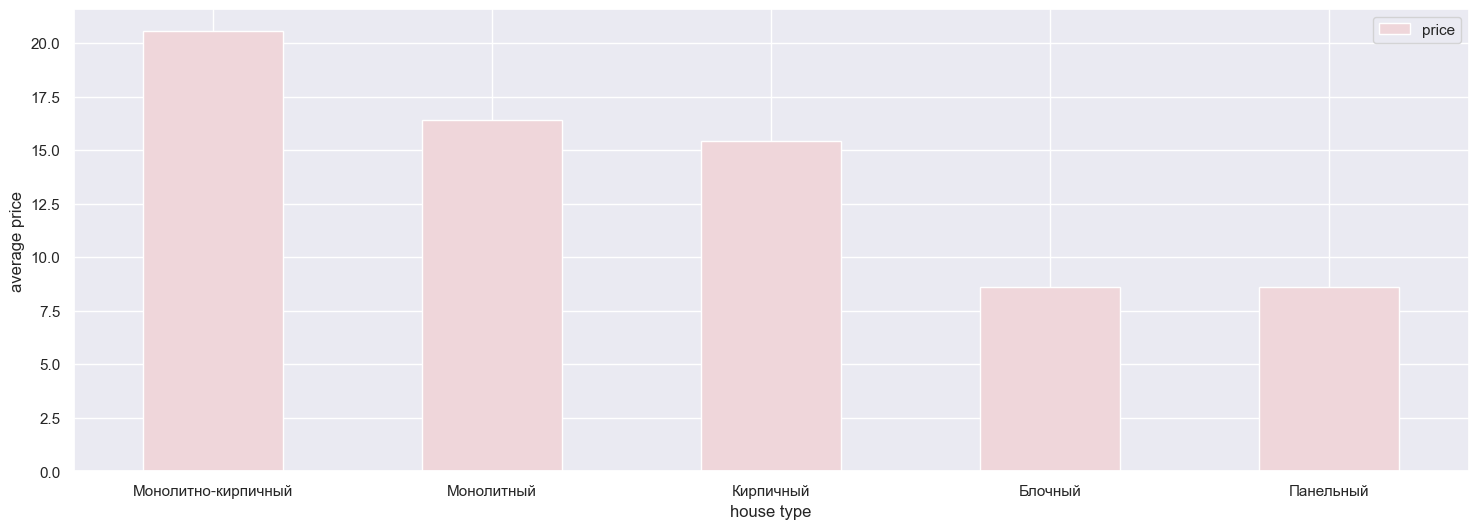

In [49]:
copy = pd.DataFrame(df.groupby(['house type'])['price'].mean().sort_values(ascending = False))
copy.plot.bar(figsize=(18,6), color="#efd6da", rot=0)
plt.xlabel("house type")
plt.ylabel("average price")
plt.show()

Наибольший средний ценник у квартир из монолитно-кирпичных домов. Скорее всего данный признак внесет довольно заметный вклад в формирование стоимости жилья.

### Ремонт

[Text(0.5, 1.0, 'renovation histogram')]

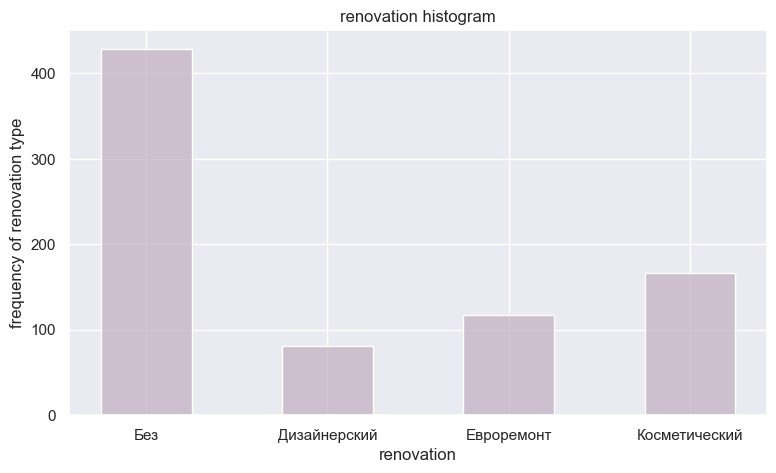

In [50]:
ax = sns.histplot(df['renovation'], shrink=0.5, color="#c3b2c4")
ax.set(xlabel='renovation', ylabel='frequency of renovation type')
ax.set(title='renovation histogram')

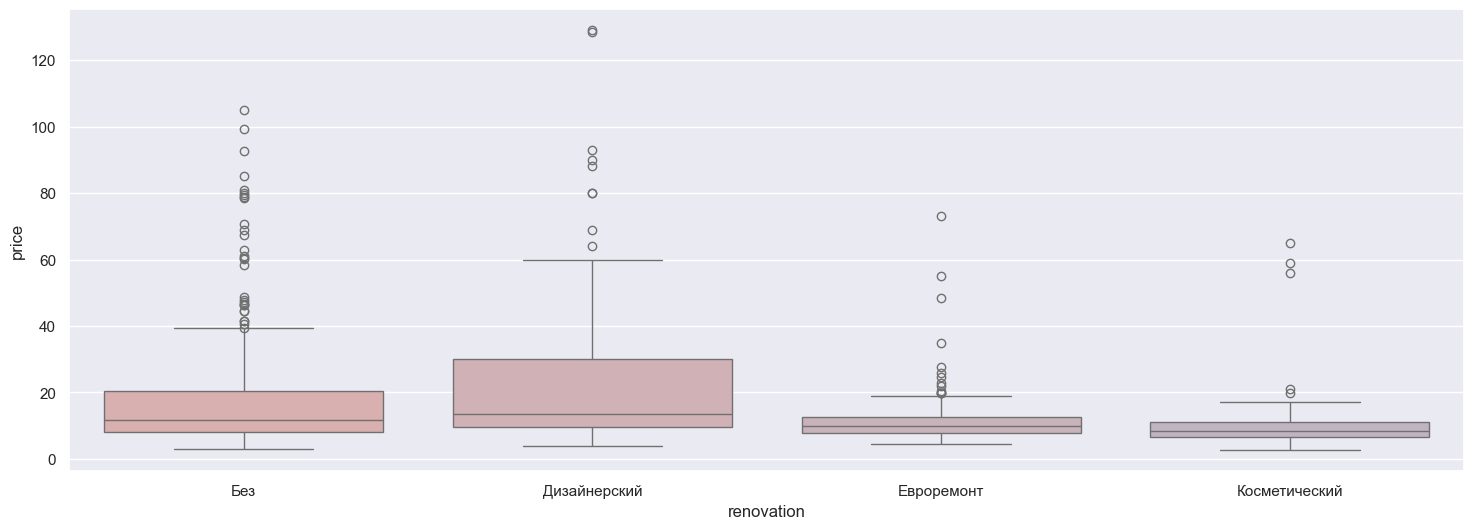

In [51]:
plt.figure(figsize=(18, 6))
chart2 = sns.boxplot(x = df["renovation"], y = df["price"], palette="blend:#dfa9a8,#c3b2c4")
plt.xlabel("renovation")
plt.ylabel("price")
plt.show();

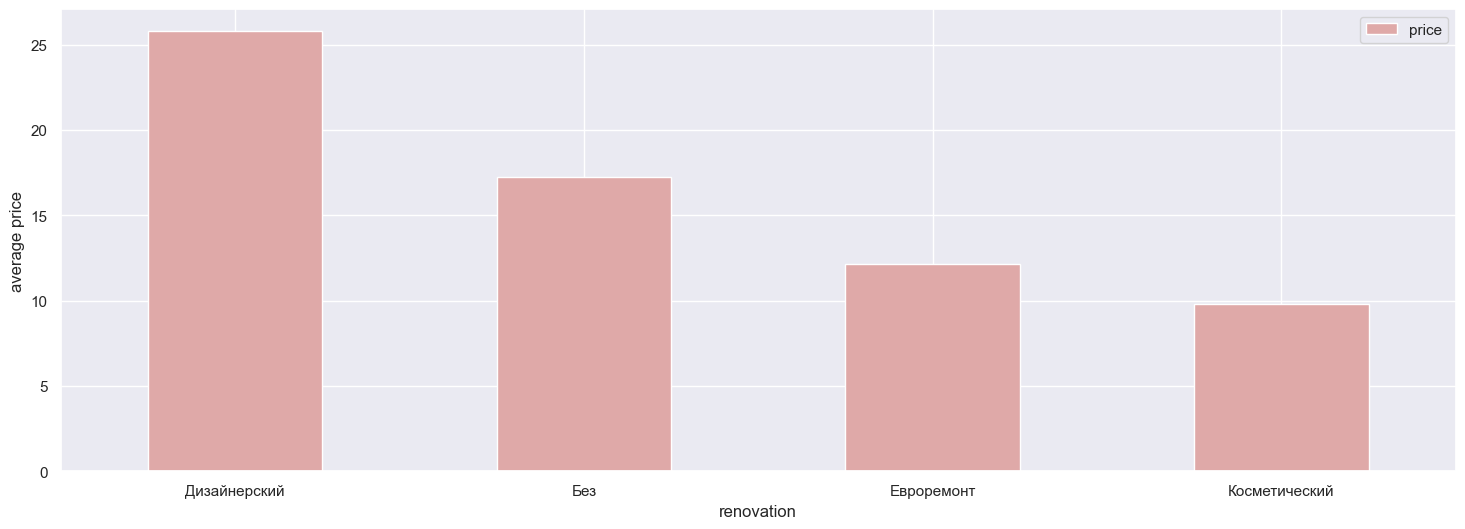

In [52]:
copy = pd.DataFrame(df.groupby(['renovation'])['price'].mean().sort_values(ascending = False))
copy.plot.bar(figsize=(18,6), color="#dfa9a8", rot=0)
plt.xlabel("renovation")
plt.ylabel("average price")
plt.show()

Чаще всего выставляют на продажу объявление о продаже квартир без ремонта или отделки, цена на них, как правило, ниже, хотя имеется значительное количество выбросов. По сравнению с другими типами ремонта квартиры с дизайнерским ремонтом отличаются довольно высокой средней стоимостью.

## Исследование численных признаков

In [147]:
def scatter(column: str, n: int) -> None:
    plt.subplot(5, 2, n)
    plt.hist2d(df[column], df['price'], bins=(50, 50), cmap=sns.cubehelix_palette(as_cmap=True))
    plt.title(column+' vs price')
    plt.ylabel('price')
    plt.xlabel(column)

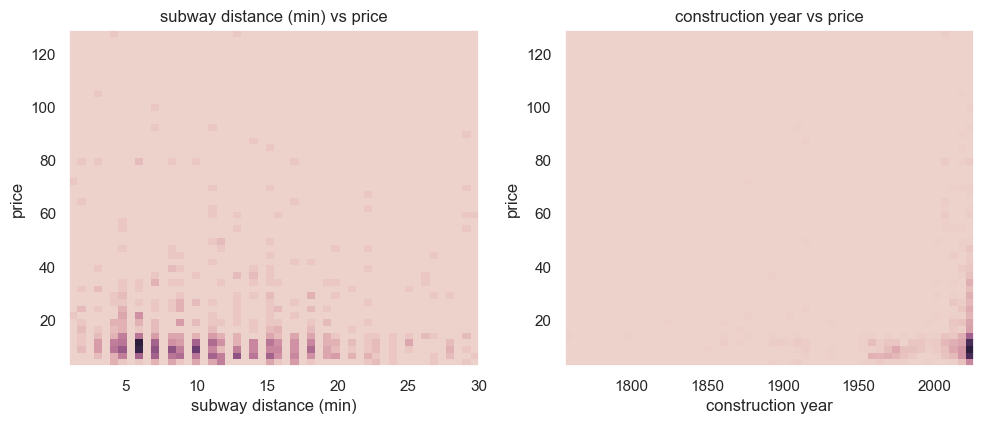

In [148]:
plt.figure(figsize=(10,20))

scatter('subway distance (min)', 1)
scatter('construction year', 2)

plt.tight_layout()

Полученные точечные диаграммы наглядно демонстрируют, что близость к метро (на удивление) не оказывает существенного влияния на таргет, ровно так же, как и год постройки, т.к. между данными величинами и ценой не наблюдается значительной корреляции от слова совсем.

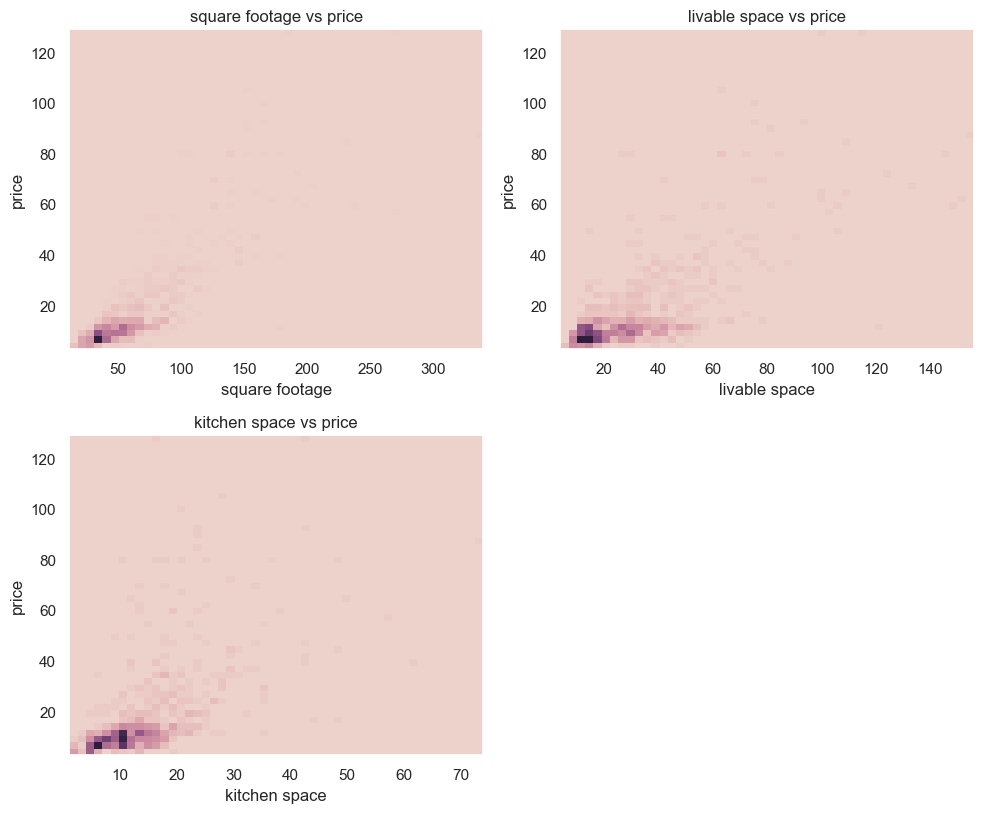

In [149]:
plt.figure(figsize=(10,20))

scatter('square footage', 1)
scatter('livable space', 2)
scatter('kitchen space', 3)

plt.tight_layout()

Между общей площадь квартиры и ценой наблюдается значительная положительная корреляция, что свидетельствует о наличии приближённой линейной зависимости. Такая же ситуация и для жилой площади помещения и цены, и площади кухни и цены.

Впоследствии будет необходимо проверить данные признаки на наличие скрытой линейной зависимости, так как в случае её наличия у вектора весов $w$ появятся очень большие по модулю компоненты (при этом сам вектор весов будет вычислен с большой погрешностью из-за деления на маленькое число). Кроме этого, все ошибки и весь шум, которые имелись в матрице $X$, при вычислении $y \sim Xw$ будут умножаться на эти большие и неточные числа и очень быстро возрастать, что приведёт к проблемам, от которых не спасёт никакое сингулярное разложение.

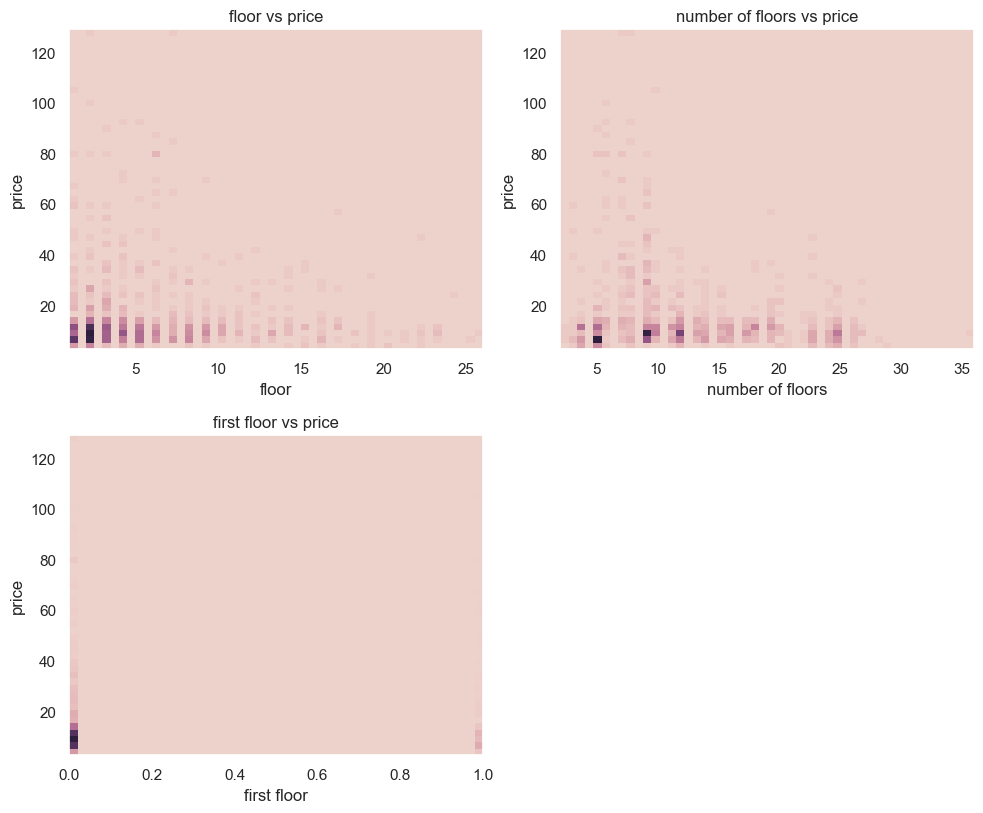

In [150]:
plt.figure(figsize=(10,20))

scatter('floor', 1)
scatter('number of floors', 2)
scatter('first floor', 3)

plt.tight_layout()

Приведённые графики показывают, что между ценой квартиры и номером этажа, на котором она расположена, между ценой и количеством этажей в доме, а также между ценой и тем, является ли этаж первым, отсутствует значительная корреляция.

Гипотеза о том, что расположение квартиры на первом этаже будет влиять на итоговую стоимость, не подтвердилась: она справедлива только в контексте одного конкретного района.

Таким образом, данные фичи можно не добавлять в датасет, на котором будет произведено обучение модели, потому что они оказывают очень малое влияние на формирование итоговой цены.


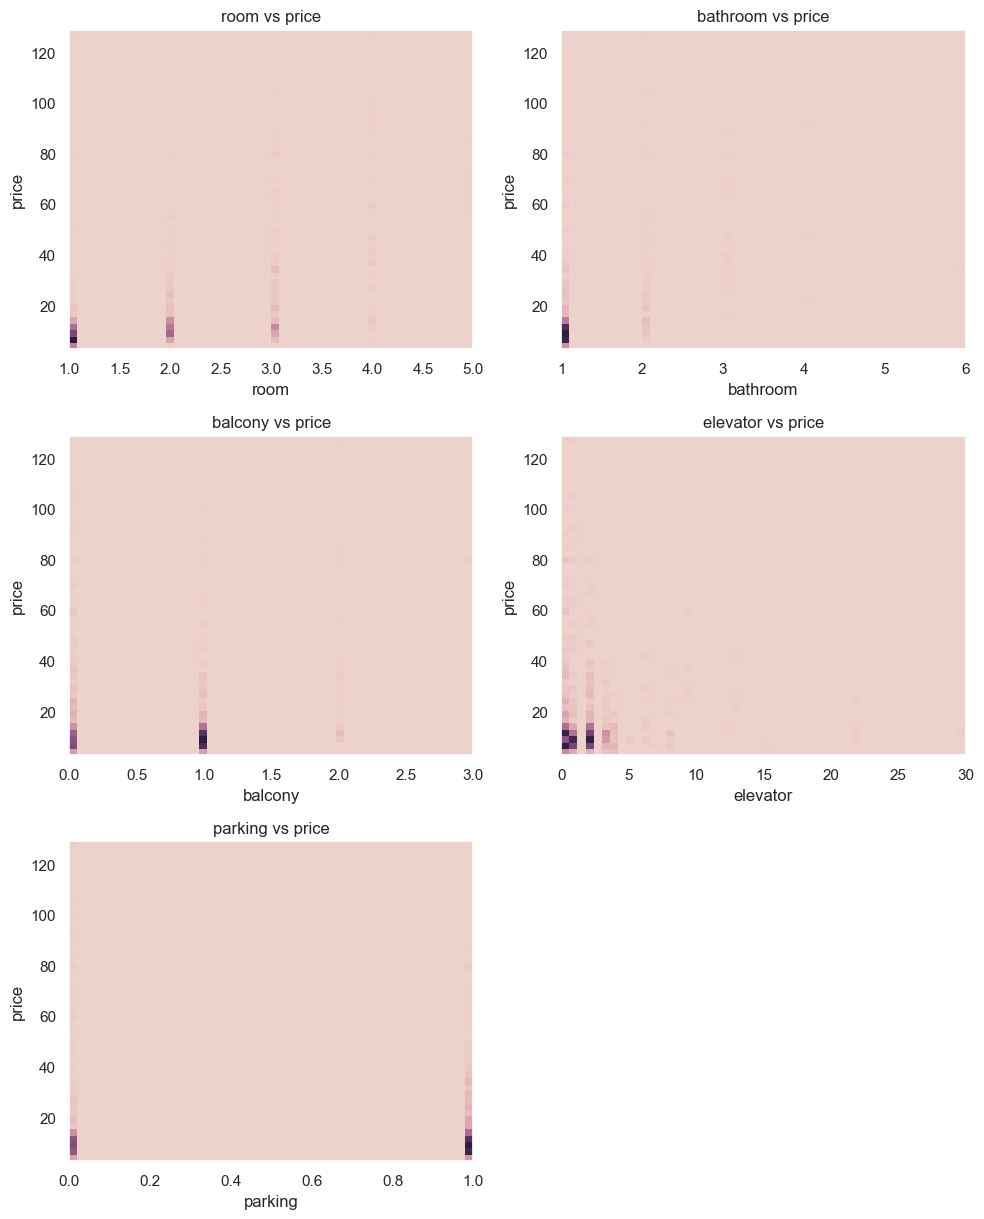

In [151]:
plt.figure(figsize=(10,20))

scatter('room', 1)
scatter('bathroom', 2)
scatter('balcony', 3)
scatter('elevator', 4)
scatter('parking', 5)

plt.tight_layout()

Из-за малого диапазона значений по диаграмме рассеивания довольно сложно определить наличие или отсутствие линейной зависимости между признаками и таргетом.

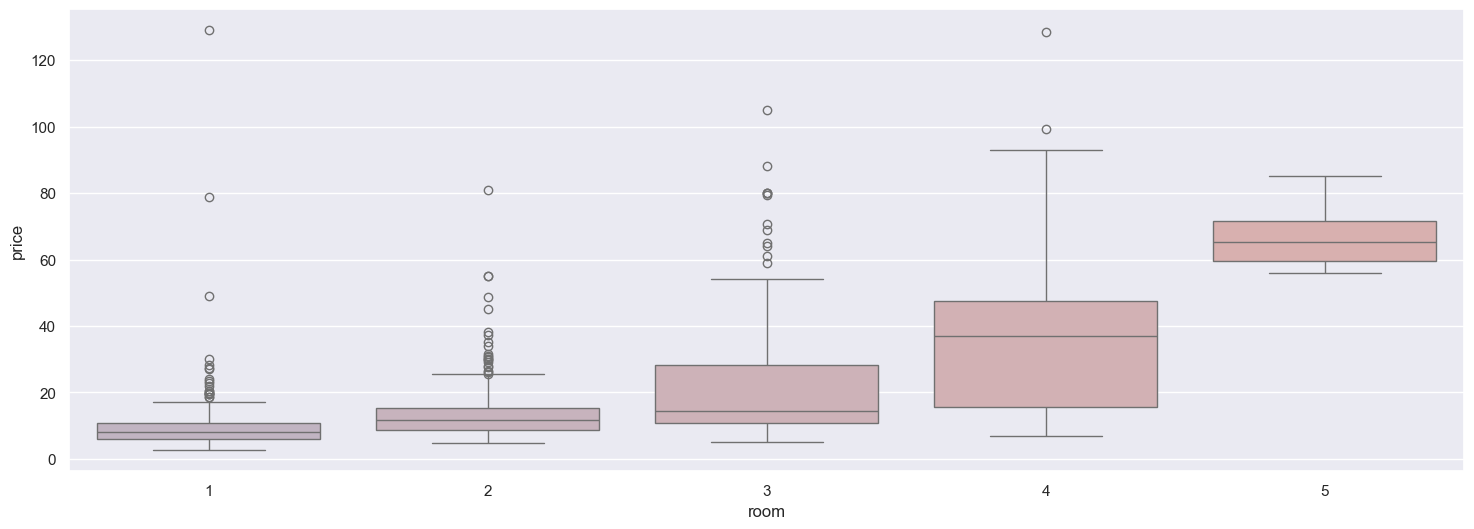

In [152]:
plt.figure(figsize=(18, 6))
chart2 = sns.boxplot(x = df["room"], y = df["price"], palette="blend:#c3b2c4,#dfa9a8")
plt.xlabel("room")
plt.ylabel("price")
plt.show();

По боксплотам видно, что с ростом количества комнат итоговая стоимость квартиры также растёт, поэтому это довольно важный признак, влияющий на таргет.

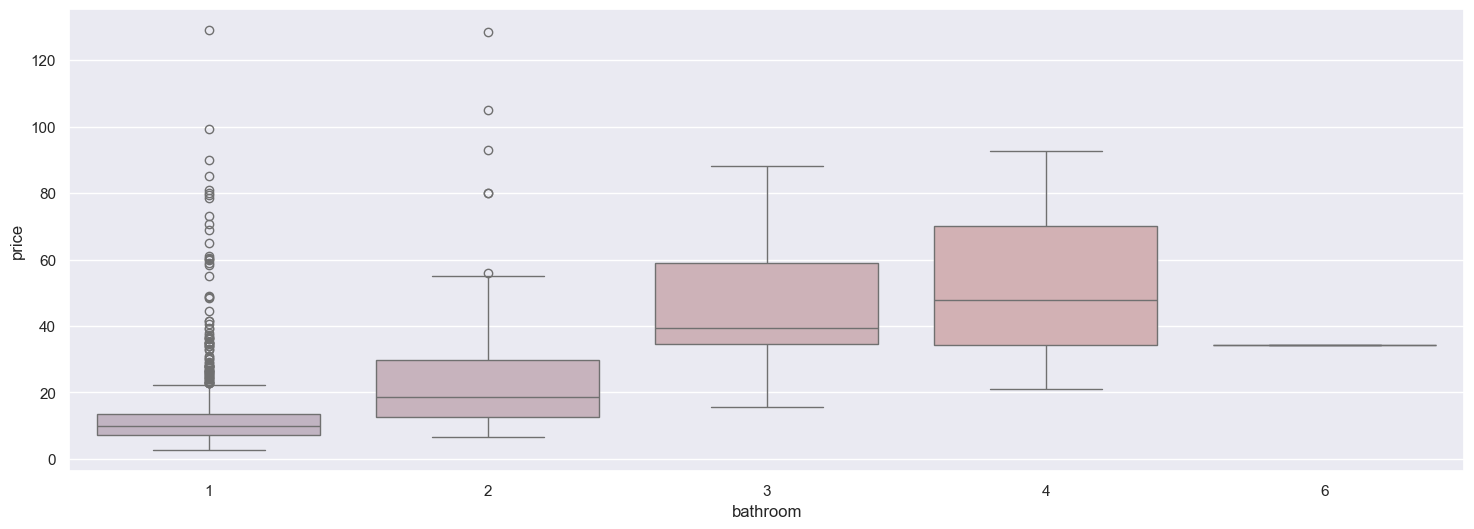

In [153]:
plt.figure(figsize=(18, 6))
chart2 = sns.boxplot(x = df["bathroom"], y = df["price"], palette="blend:#c3b2c4,#dfa9a8")
plt.xlabel("bathroom")
plt.ylabel("price")
plt.show();

С количеством ванных также растёт и стоимость жилья, данный признак стоить добавить в датасет, на котором будет производиться обучение модели. Также стоит обратить внимание на выбросы в случае, если количество ванных комнат равно 1.

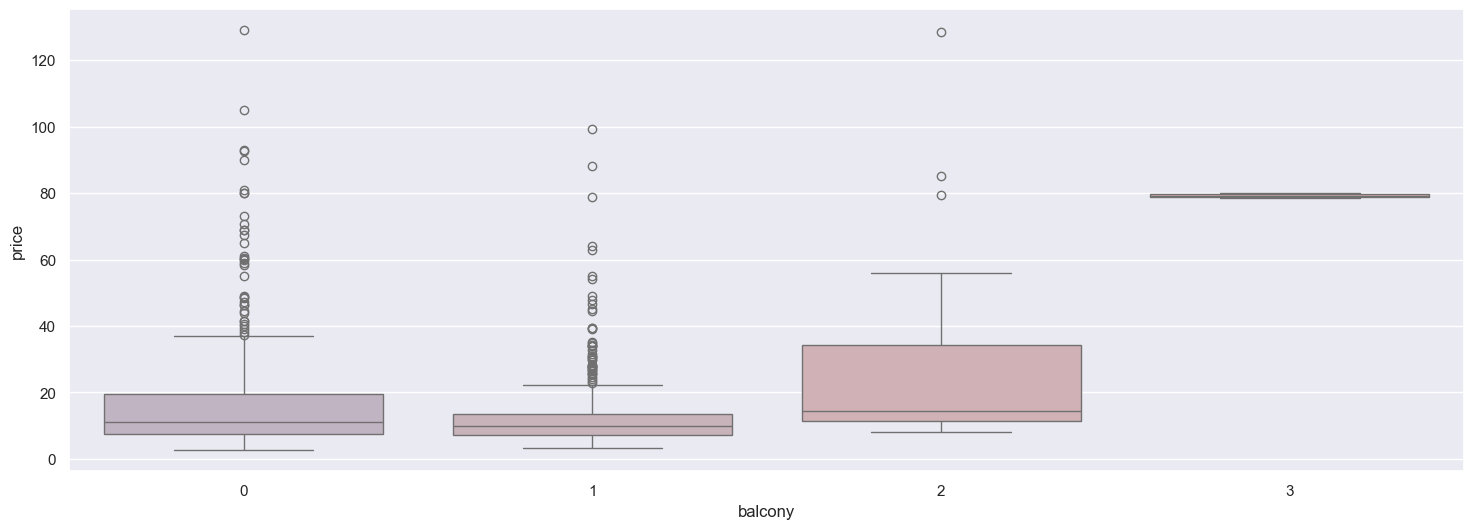

In [154]:
plt.figure(figsize=(18, 6))
chart2 = sns.boxplot(x = df["balcony"], y = df["price"], palette="blend:#c3b2c4,#dfa9a8")
plt.xlabel("balcony")
plt.ylabel("price")
plt.show();

С ростом количества балконов растёт и стоимость жилья, хотя также имеется довольно много выбросов, поэтому нельзя сказать однозначно, имеется ли линейная зависимость между этим признаком и ценой квартиры.

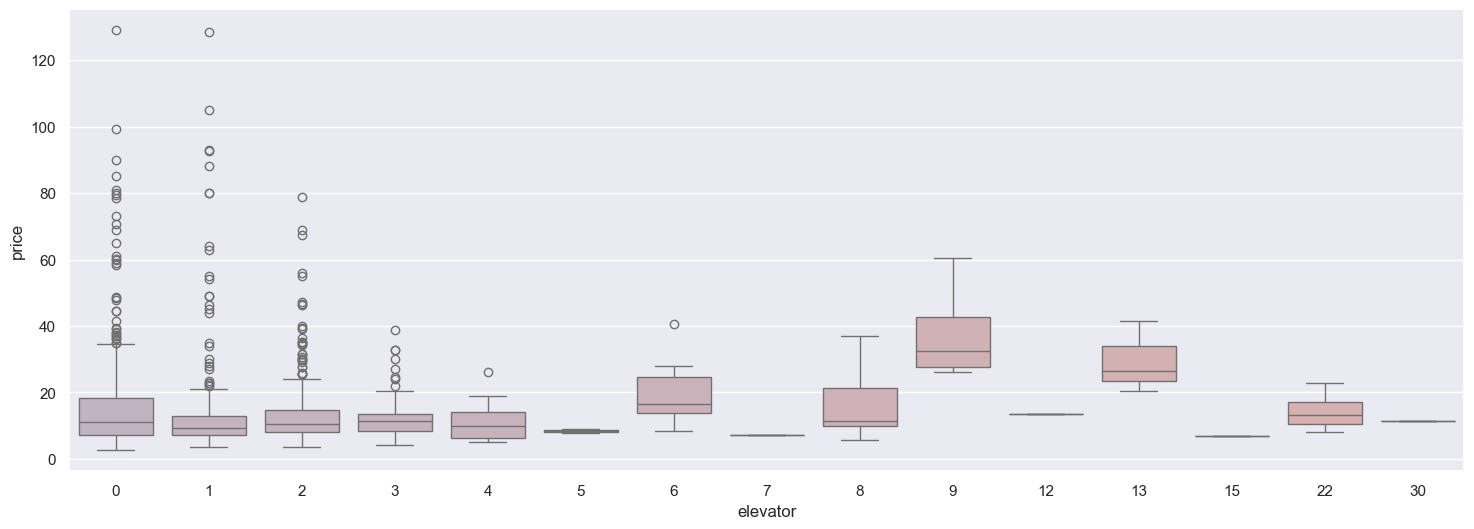

In [155]:
plt.figure(figsize=(18, 6))
chart2 = sns.boxplot(x = df["elevator"], y = df["price"], palette="blend:#c3b2c4,#dfa9a8")
plt.xlabel("elevator")
plt.ylabel("price")
plt.show()

По боксплотам видно, что количество лифтов не оказывает особого влияния на формирование итоговой стоимость жилья.

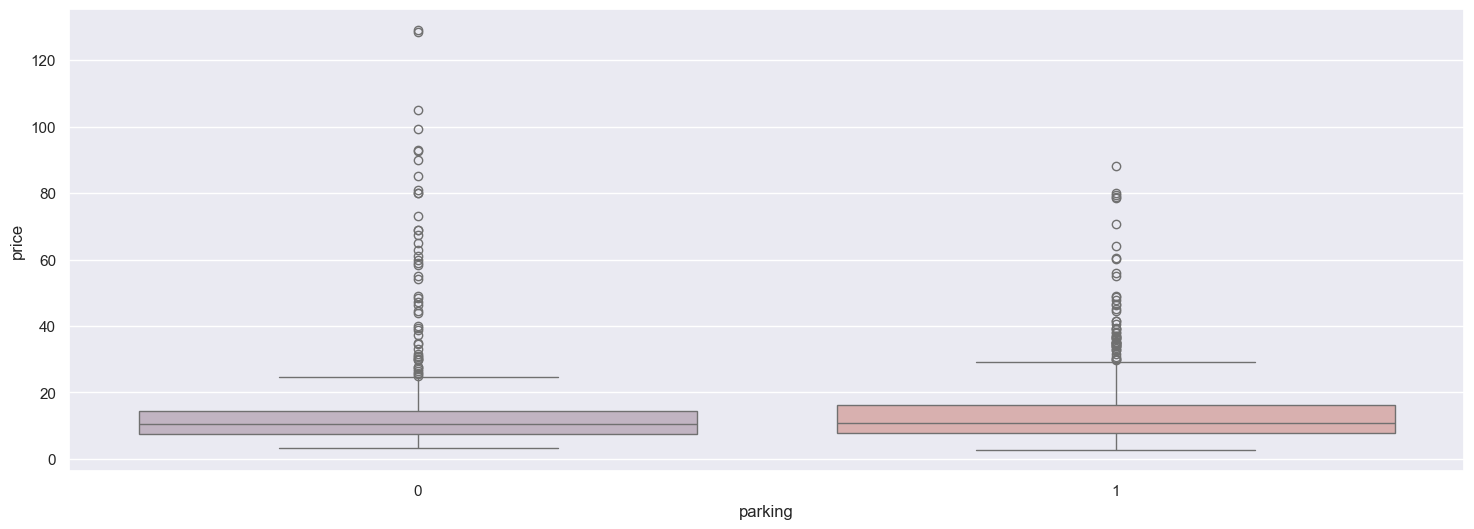

In [156]:
plt.figure(figsize=(18, 6))
chart2 = sns.boxplot(x = df["parking"], y = df["price"], palette="blend:#c3b2c4,#dfa9a8")
plt.xlabel("parking")
plt.ylabel("price")
plt.show();

Наличие парковки несильно влияет на итоговую стоимость квартиры.
У квартир, у которых парковка не предусмотрена, также наблюдается большое количество выбросов.

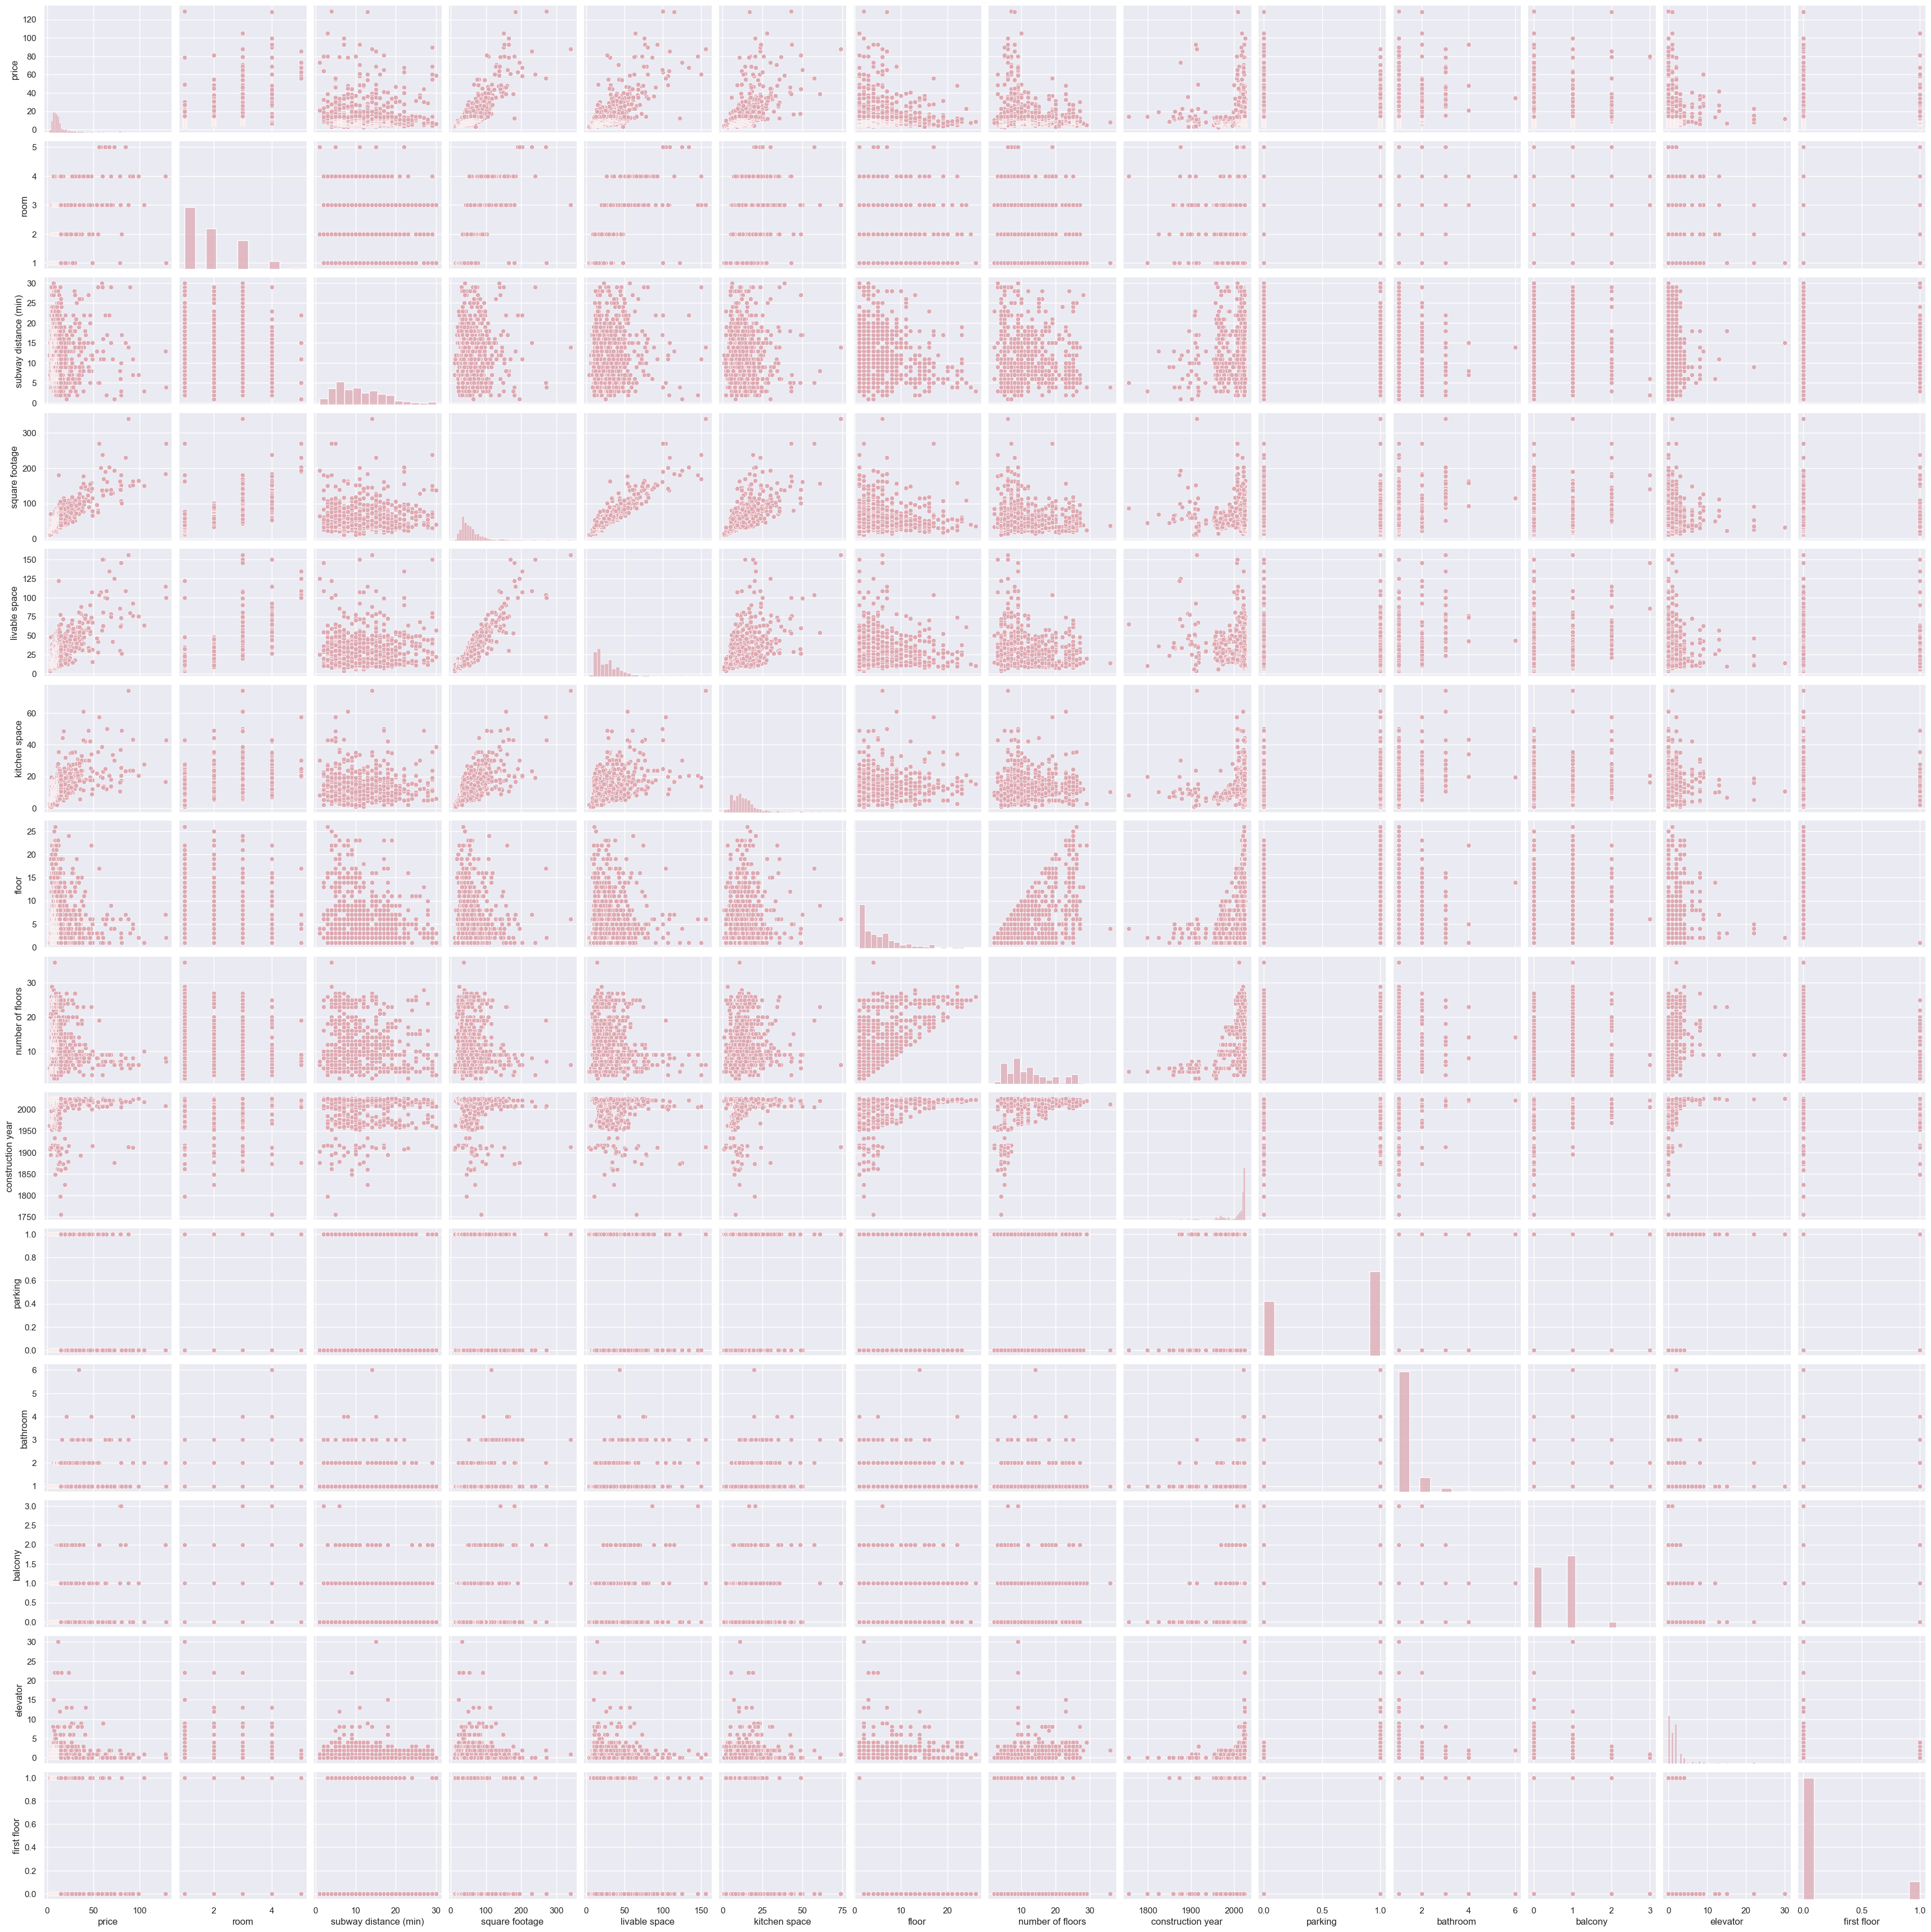

In [63]:
sns.set_palette("blend:#dda9b2,#aa83a6")
df.drop(columns=['id', 'price_zscore'], inplace=True)
sns.pairplot(df)
plt.show()

Между такими численным признаками, как общая площадь квартиры, жилая площадь и площадь кухни наблюдается скрытая линейная зависимость.

Если между признаками есть приближённая линейная зависимость, коэффициенты в линейной модели могут совершенно потерять физический смысл.
Малые погрешности признаков сильно возрастают при предсказании ответа, а в градиентном спуске накапливается погрешность из-за операций со слишком большими числами. Мультиколлинеарность делает модель не только неточной, но и принципиально не интерпретируемой.

Таким образом, чтобы в дальнейшем избежать вычислительных трудностей, необходимо оставить только один из перечисленных признаков, пусть это будет общая площадь помещения (square footage).

In [64]:
df.columns

Index(['price', 'room', 'district', 'subway', 'subway distance (min)',
       'square footage', 'livable space', 'kitchen space', 'floor',
       'number of floors', 'construction year', 'parking', 'apartment type',
       'house type', 'renovation', 'bathroom', 'balcony', 'elevator',
       'first floor'],
      dtype='object')

In [65]:
features = ['price', 'district', 'subway', 'room', 'square footage', 'floor', 'parking', 'apartment type', 'house type', 'renovation', 'bathroom', 'balcony', 'elevator']
df_lr = df[features]

## Бинаризация

Чтобы решить проблему создания $N$ дополнительных бинарных фич, где $N$ - мощность множетсва категорий этого атрибута, возникающую при использовании one-hot encoding'а, для маппинга категориальных переменных в числовые значения воспользуемся binary encoding'ом: он работает, как label-encoding, только в двоичном представлении номера категории.
За счет такого подхода мы создадим не $N$, а $\log_2(N)$ дополнительных бинарных фич.

In [66]:
encoder = BinaryEncoder(cols=['district'], drop_invariant=True)
df_lr = encoder.fit_transform(df_lr)

In [67]:
encoder = BinaryEncoder(cols=['subway'], drop_invariant=True)
df_lr = encoder.fit_transform(df_lr)

In [68]:
encoder = BinaryEncoder(cols=['apartment type'], drop_invariant=True)
df_lr = encoder.fit_transform(df_lr)

In [69]:
encoder = BinaryEncoder(cols=['house type'], drop_invariant=True)
df_lr = encoder.fit_transform(df_lr)

In [70]:
encoder = BinaryEncoder(cols=['renovation'], drop_invariant=True)
df_lr = encoder.fit_transform(df_lr)

In [71]:
df_lr.head

<bound method NDFrame.head of           price  district_0  district_1  district_2  district_3  district_4  \
2     23.931708           0           0           0           0           1   
4     48.700000           0           0           0           1           0   
5     36.000000           0           0           0           0           1   
6     70.726917           0           0           0           1           0   
12     9.278465           0           0           0           1           1   
...         ...         ...         ...         ...         ...         ...   
1345  14.569788           0           0           1           0           1   
1351  14.726920           0           1           0           1           0   
1353  14.800000           0           1           0           1           1   
1354  14.846500           0           1           0           1           1   
1355  14.933280           0           1           1           0           0   

      subway_0  subwa

In [72]:
df_lr.shape

(794, 28)

## Стандартизация

В случае, если в дальнейшем будет использована модель, требующая стандартного распределения всех признаков, необходимо произвести их стандартизацию. Равенство матожидания нулю позволит обеспечить, к примеру, быстросходящийся стохастический градиентный спуск в линейной регрессии.

Для того чтобы сохранить полезную информацию о выбросах и сделать алгоритм менее чувствительным к ним, приведём вектор признаков к стандартному нормальному распределению, то есть виду, в котором его матожидание равно $0$, а дисперсия - $1$:
$x^'_{ij}=\frac{x_{ij}-\mu_j}{\sigma_j}$, где $\mu_j$ - среднее значение $j$-ого признака в обучающей выборке, а  $\sigma_j$ - его стандартное отклонение.

In [73]:
ssc = StandardScaler()
df_lr[df_lr.columns] = ssc.fit_transform(df_lr[df_lr.columns])

In [74]:
df_lr

price  district_0  district_1  district_2  district_3  district_4  \
2     0.511923   -0.278102   -1.028103   -0.789761   -0.890126    1.155549   
4     2.068065   -0.278102   -1.028103   -0.789761    1.123436   -0.865389   
5     1.270149   -0.278102   -1.028103   -0.789761   -0.890126    1.155549   
6     3.451971   -0.278102   -1.028103   -0.789761    1.123436   -0.865389   
12   -0.408711   -0.278102   -1.028103   -0.789761    1.123436    1.155549   
...        ...         ...         ...         ...         ...         ...   
1345 -0.076268   -0.278102   -1.028103    1.266206   -0.890126    1.155549   
1351 -0.066395   -0.278102    0.972666   -0.789761    1.123436   -0.865389   
1353 -0.061804   -0.278102    0.972666   -0.789761    1.123436    1.155549   
1354 -0.058882   -0.278102    0.972666   -0.789761    1.123436    1.155549   
1355 -0.053430   -0.278102    0.972666    1.266206   -0.890126   -0.865389   

      subway_0  subway_1  subway_2  subway_3  ...  apartment type_1  \
2    -0.112938 -0.852107 -0.836788 -1.062397  ...          1.137892   
4    -0.112938 -0.852107 -0.836788 -1.062397  ...          1.137892   
5    -0.112938 -0.852107 -0.836788 -1.062397  ...         -0.878818   
6    -0.112938 -0.852107 -0.836788 -1.062397  ...          1.137892   
12   -0.112938 -0.852107 -0.836788 -1.062397  ...          1.137892   
...        ...       ...       ...       ...  ...               ...   
1345 -0.112938 -0.852107 -0.836788 -1.062397  ...          1.137892   
1351 -0.112938  1.173561  1.195046  0.941268  ...          1.137892   
1353 -0.112938  1.173561 -0.836788 -1.062397  ...         -0.878818   
1354 -0.112938  1.173561 -0.836788 -1.062397  ...          1.137892   
1355 -0.112938  1.173561 -0.836788 -1.062397  ...          1.137892   

      house type_0  house type_1  house type_2  renovation_0  renovation_1  \
2        -0.409447     -0.775117      0.535604     -0.516089     -0.576381   
4        -0.409447     -0.775117      0.535604     -0.516089     -0.576381   
5        -0.409447      1.290128     -1.867050     -0.516089      1.734964   
6        -0.409447     -0.775117      0.535604     -0.516089     -0.576381   
12       -0.409447      1.290128      0.535604     -0.516089     -0.576381   
...            ...           ...           ...           ...           ...   
1345     -0.409447     -0.775117      0.535604     -0.516089     -0.576381   
1351     -0.409447     -0.775117      0.535604     -0.516089     -0.576381   
1353     -0.409447     -0.775117      0.535604     -0.516089     -0.576381   
1354     -0.409447     -0.775117      0.535604     -0.516089     -0.576381   
1355     -0.409447     -0.775117      0.535604     -0.516089     -0.576381   

      renovation_2  bathroom   balcony  elevator  
2         0.673953 -0.355647 -1.049929 -0.641599  
4         0.673953 -0.355647 -1.049929 -0.641599  
5        -1.483783 -0.355647 -1.049929 -0.641599  
6         0.673953 -0.355647 -1.049929 -0.641599  
12        0.673953 -0.355647 -1.049929  1.718693  
...            ...       ...       ...       ...  
1345      0.673953  1.647074  0.668924  0.931929  
1351      0.673953 -0.355647  0.668924 -0.641599  
1353      0.673953  1.647074  0.668924  0.145165  
1354      0.673953  1.647074  0.668924 -0.641599  
1355      0.673953 -0.355647  0.668924  0.145165  

[794 rows x 28 columns]

In [75]:
df['price'].describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1])

count    794.000000
mean      15.783699
std       15.926508
min        2.600000
25%        7.600597
50%       10.600000
75%       15.471754
85%       24.500761
90%       32.799660
100%     129.000000
max      129.000000
Name: price, dtype: float64

In [76]:
df_lr['price'].describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1])

count    794.000000
mean       0.000000
std        1.000630
min       -0.828305
25%       -0.514128
50%       -0.325681
75%       -0.019599
85%        0.547675
90%        1.069078
100%       7.113151
max        7.113151
Name: price, dtype: float64

## Нормализация

Для выравнивания параметров распределения между разными числовыми атрибутами, чтобы веса более явно говорили о важности признаков, приведем значения к масштабу $[0;1]$:
$x = x - \min(x), \; x  = \frac{x}{\max(x)}$


In [77]:
# msc = MinMaxScaler()
# df_lr[df_lr.columns] = msc.fit_transform(df_lr[df_lr.columns])

In [78]:
# df_lr

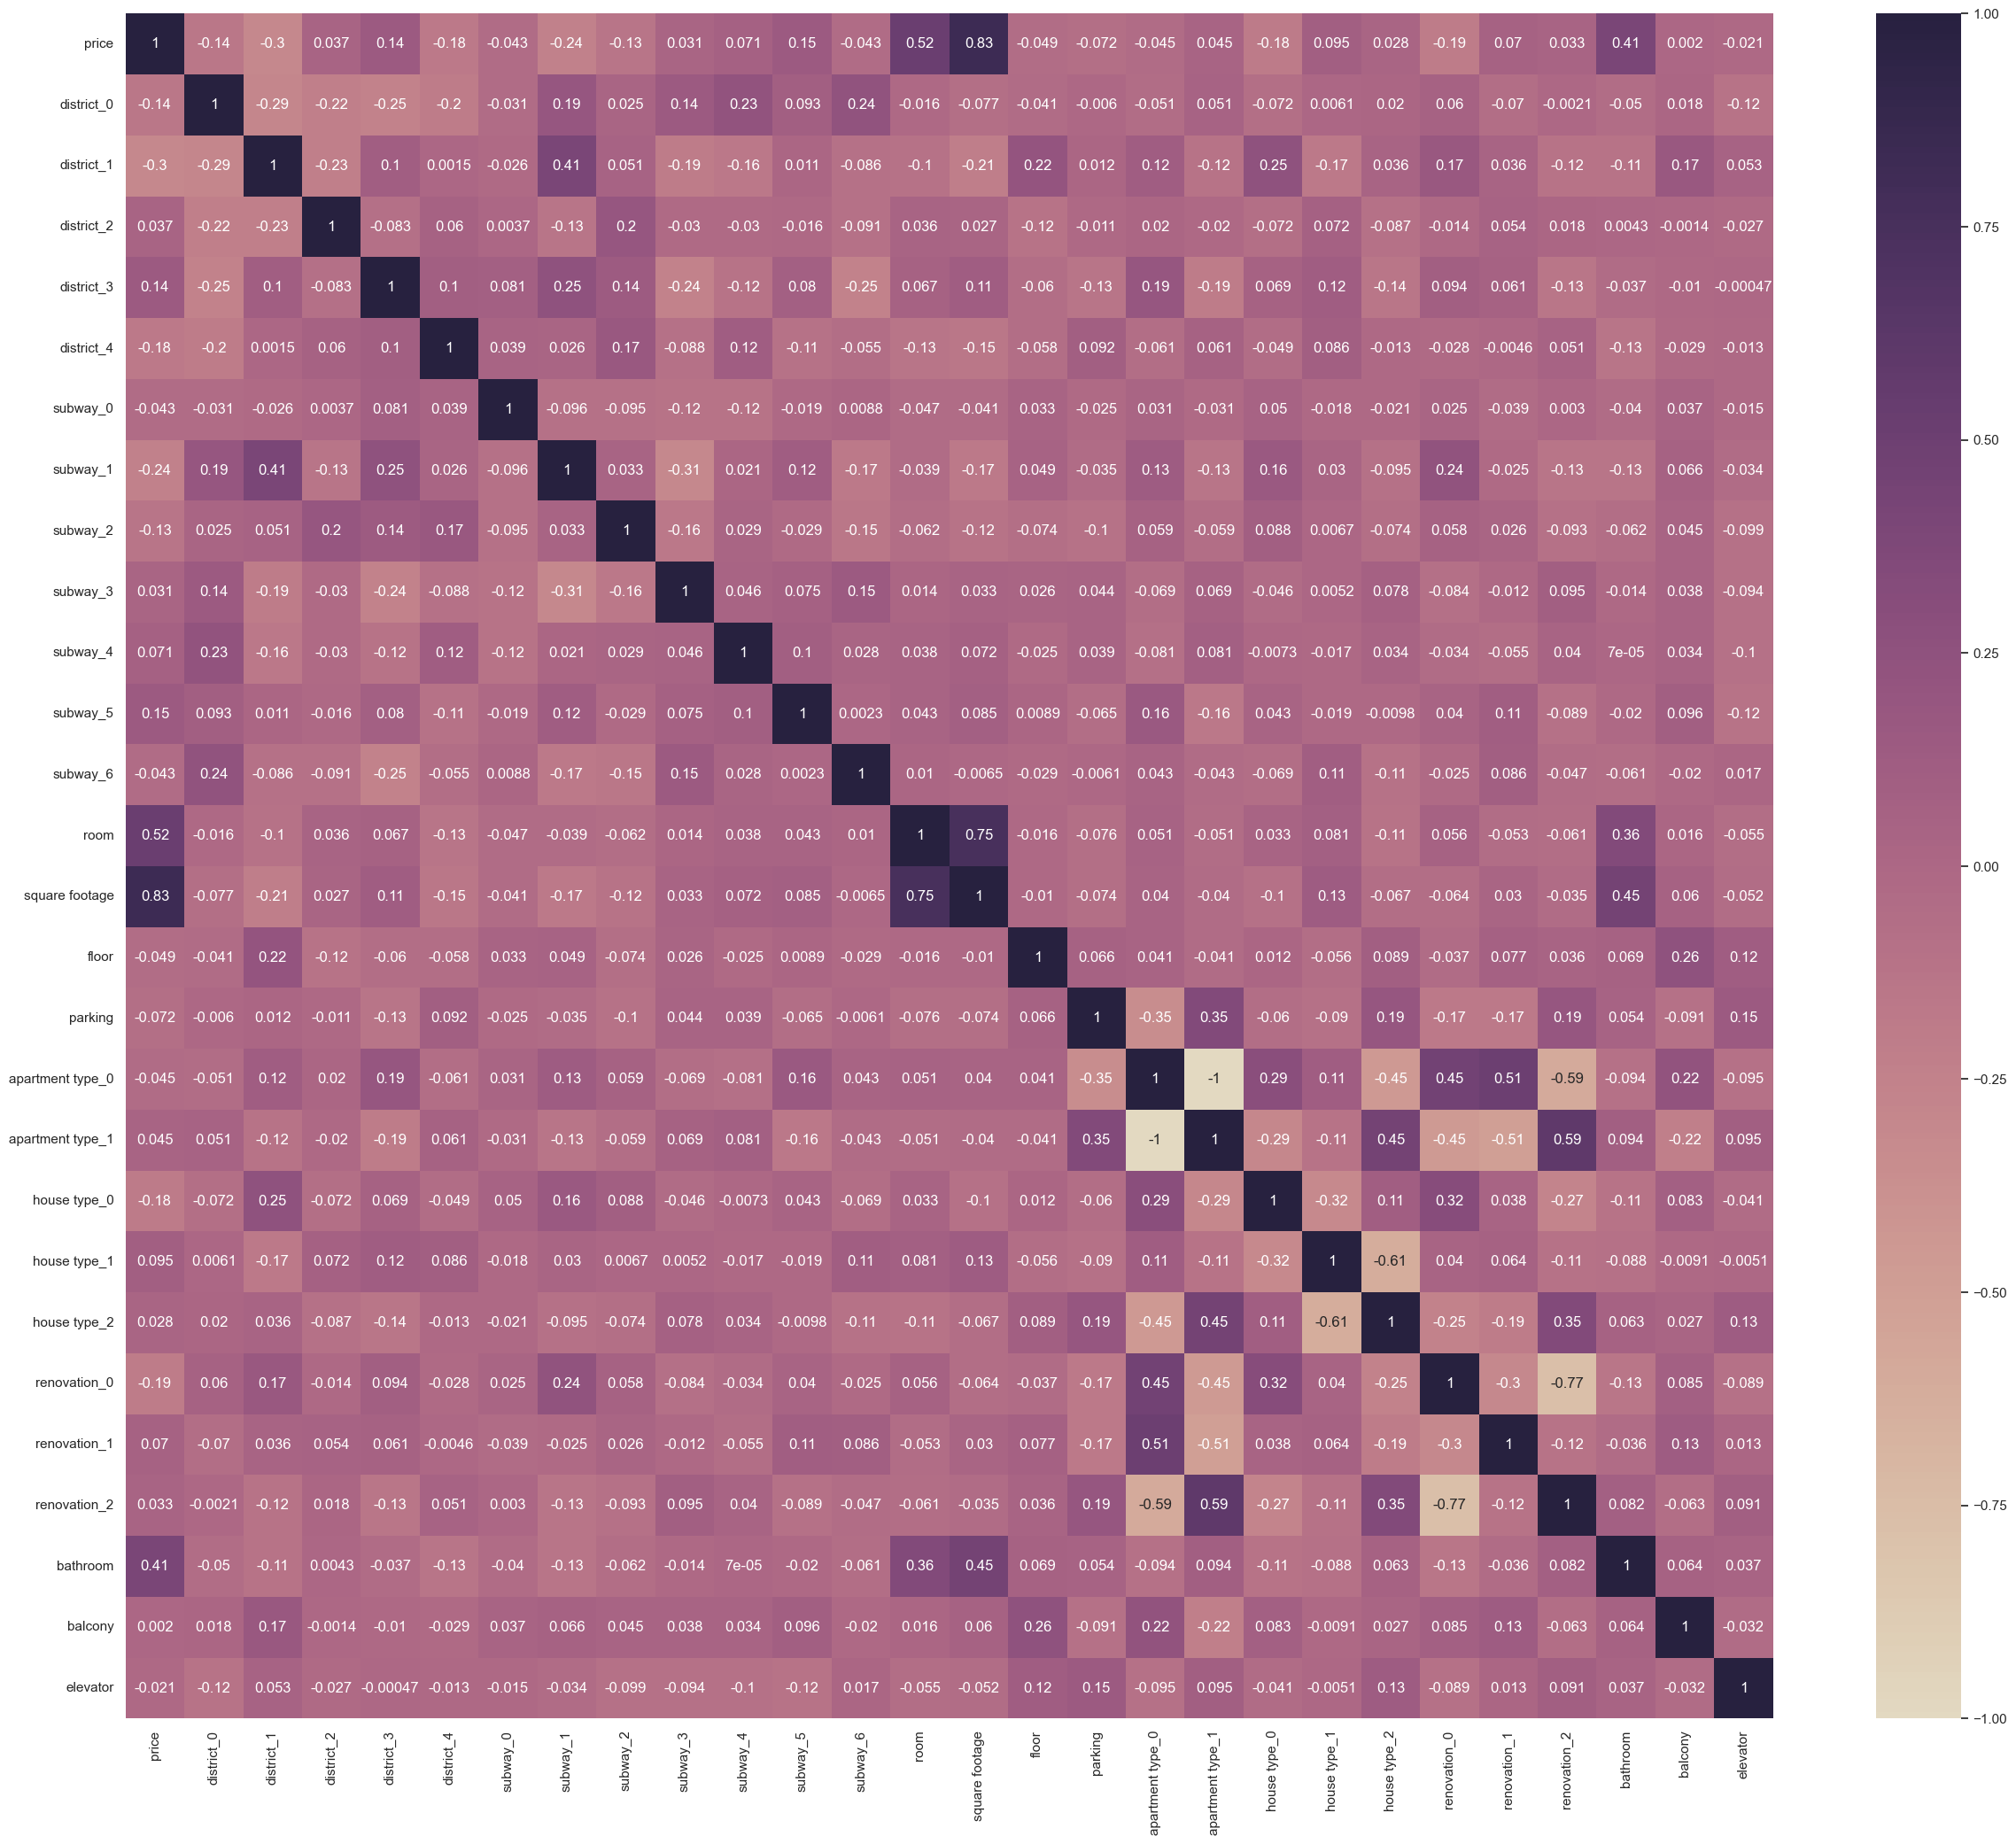

In [146]:
# correlation using heatmap
plt.figure(figsize = (30, 25))
sns.heatmap(df_lr.corr(), annot = True, cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))
plt.show()

Итоговая цена квартиры во многом зависит от количества комнат, общей площади, а также количества ванных, так как эти признаки имеют значение коэффициента корреляции $>0.4$, что свидетельствует о наличии линейной зависимости между признаком и таргетом.
Таким образом, главными факторами прогнозирования станут именно эти категориальные и численные переменные.

# Разделение выборки на train, test, validate

In [80]:
df_lr

price  district_0  district_1  district_2  district_3  district_4  \
2     0.511923   -0.278102   -1.028103   -0.789761   -0.890126    1.155549   
4     2.068065   -0.278102   -1.028103   -0.789761    1.123436   -0.865389   
5     1.270149   -0.278102   -1.028103   -0.789761   -0.890126    1.155549   
6     3.451971   -0.278102   -1.028103   -0.789761    1.123436   -0.865389   
12   -0.408711   -0.278102   -1.028103   -0.789761    1.123436    1.155549   
...        ...         ...         ...         ...         ...         ...   
1345 -0.076268   -0.278102   -1.028103    1.266206   -0.890126    1.155549   
1351 -0.066395   -0.278102    0.972666   -0.789761    1.123436   -0.865389   
1353 -0.061804   -0.278102    0.972666   -0.789761    1.123436    1.155549   
1354 -0.058882   -0.278102    0.972666   -0.789761    1.123436    1.155549   
1355 -0.053430   -0.278102    0.972666    1.266206   -0.890126   -0.865389   

      subway_0  subway_1  subway_2  subway_3  ...  apartment type_1  \
2    -0.112938 -0.852107 -0.836788 -1.062397  ...          1.137892   
4    -0.112938 -0.852107 -0.836788 -1.062397  ...          1.137892   
5    -0.112938 -0.852107 -0.836788 -1.062397  ...         -0.878818   
6    -0.112938 -0.852107 -0.836788 -1.062397  ...          1.137892   
12   -0.112938 -0.852107 -0.836788 -1.062397  ...          1.137892   
...        ...       ...       ...       ...  ...               ...   
1345 -0.112938 -0.852107 -0.836788 -1.062397  ...          1.137892   
1351 -0.112938  1.173561  1.195046  0.941268  ...          1.137892   
1353 -0.112938  1.173561 -0.836788 -1.062397  ...         -0.878818   
1354 -0.112938  1.173561 -0.836788 -1.062397  ...          1.137892   
1355 -0.112938  1.173561 -0.836788 -1.062397  ...          1.137892   

      house type_0  house type_1  house type_2  renovation_0  renovation_1  \
2        -0.409447     -0.775117      0.535604     -0.516089     -0.576381   
4        -0.409447     -0.775117      0.535604     -0.516089     -0.576381   
5        -0.409447      1.290128     -1.867050     -0.516089      1.734964   
6        -0.409447     -0.775117      0.535604     -0.516089     -0.576381   
12       -0.409447      1.290128      0.535604     -0.516089     -0.576381   
...            ...           ...           ...           ...           ...   
1345     -0.409447     -0.775117      0.535604     -0.516089     -0.576381   
1351     -0.409447     -0.775117      0.535604     -0.516089     -0.576381   
1353     -0.409447     -0.775117      0.535604     -0.516089     -0.576381   
1354     -0.409447     -0.775117      0.535604     -0.516089     -0.576381   
1355     -0.409447     -0.775117      0.535604     -0.516089     -0.576381   

      renovation_2  bathroom   balcony  elevator  
2         0.673953 -0.355647 -1.049929 -0.641599  
4         0.673953 -0.355647 -1.049929 -0.641599  
5        -1.483783 -0.355647 -1.049929 -0.641599  
6         0.673953 -0.355647 -1.049929 -0.641599  
12        0.673953 -0.355647 -1.049929  1.718693  
...            ...       ...       ...       ...  
1345      0.673953  1.647074  0.668924  0.931929  
1351      0.673953 -0.355647  0.668924 -0.641599  
1353      0.673953  1.647074  0.668924  0.145165  
1354      0.673953  1.647074  0.668924 -0.641599  
1355      0.673953 -0.355647  0.668924  0.145165  

[794 rows x 28 columns]

In [81]:
X = df_lr.drop('price', axis=1).values
y = df_lr['price']

In [82]:
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, shuffle=True)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, shuffle=True) # 0.25 x 0.8 = 0.2

При переобучении модели и формировании окончательной комбинации гиперпараметров важно иметь кусок датасета val,
на котором происходит оптимизация и подсчет какой-либо метрики, и отдельный тестовый набор test, который подается модели в первый раз для объективного формирования оценки модели.

Другими словами, при подборе гиперпараметров сразу на тестовом множестве велика вероятность получить overfit, т.к. гиперпараметры будут "подстраиваться" под тестовую выборку.

Для подбора гиперпараметров будем использовать GridSearchCV, который включает в себя кросс-валидацию, поэтому отдельно делить train на train+val не будем.

# sklearn ElasticNet

## Подбор гиперпараметров модели с помощью GridSearchCV

В датасате не так много данных, поэтому с помощью кросс-валидации используем их эффективно.

Так как однократное вычисление качества может быть ненадежным, лучше проводить серию из вычислений метрик. Вместо привычного разбиения на большой батч train+val и большой батч test, данные можно разбить на несколько подмножеств и скармливать какие-то данные для обучения, а оставшиеся - для тестирования (далее перемешивать данные и повторять цикл обучения и оценки несколько раз).

GridSearchCV использует Stratified k-fold CV: каждый блок содержит примерно такое же соотношение классов, как и все исходное множество. Такое может быть полезно в случае очень несбалансированного соотношения классов.

In [83]:
param_grid = {
                'alpha'     : np.logspace(-5, 5, 100, endpoint=True),
                'l1_ratio'  :  np.arange(0, 1.1, 0.1)
            }

regressor = ElasticNet(max_iter=10000)

grid_search = GridSearchCV(regressor, param_grid, scoring="r2", cv=5, verbose=0, refit=True)
grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, estimator=ElasticNet(max_iter=10000),
             param_grid={'alpha': array([1.00000000e-05, 1.26185688e-05, 1.59228279e-05, 2.00923300e-05,
       2.53536449e-05, 3.19926714e-05, 4.03701726e-05, 5.09413801e-05,
       6.42807312e-05, 8.11130831e-05, 1.02353102e-04, 1.29154967e-04,
       1.62975083e-04, 2.05651231e-04, 2.59502421e-04, 3.27454916e-04,
       4.13201240e-04, 5.21400829e-0...
       1.20450354e+03, 1.51991108e+03, 1.91791026e+03, 2.42012826e+03,
       3.05385551e+03, 3.85352859e+03, 4.86260158e+03, 6.13590727e+03,
       7.74263683e+03, 9.77009957e+03, 1.23284674e+04, 1.55567614e+04,
       1.96304065e+04, 2.47707636e+04, 3.12571585e+04, 3.94420606e+04,
       4.97702356e+04, 6.28029144e+04, 7.92482898e+04, 1.00000000e+05]),
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring='r2')

In [84]:
print("best parameters : {}".format(grid_search.best_params_))
print("best estimator: {}".format(grid_search.best_estimator_))
print("best cross validation score: {:.2f}".format(grid_search.best_score_))

best parameters : {'alpha': 0.010722672220103232, 'l1_ratio': 0.5}
best estimator: ElasticNet(alpha=0.010722672220103232, max_iter=10000)
best cross validation score: 0.75


In [85]:
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values(['mean_test_score'], ascending = False)[:10]

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
335       0.001849      0.000253         0.000817        0.000187    0.010723   
326       0.002068      0.000715         0.000909        0.000153    0.008498   
327       0.001474      0.000348         0.000774        0.000164    0.008498   
336       0.001729      0.000367         0.000828        0.000177    0.010723   
325       0.002230      0.000517         0.000986        0.000496    0.008498   
318       0.001401      0.000229         0.000727        0.000108    0.006734   
345       0.001631      0.000249         0.000749        0.000209     0.01353   
317       0.001476      0.000091         0.001028        0.000579    0.006734   
328       0.001540      0.000336         0.000718        0.000118    0.008498   
337       0.001481      0.000345         0.000670        0.000087    0.010723   

    param_l1_ratio                                             params  \
335            0.5   {'alpha': 0.010722672220103232, 'l1_ratio': 0.5}   
326            0.7  {'alpha': 0.008497534359086439, 'l1_ratio': 0....   
327            0.8   {'alpha': 0.008497534359086439, 'l1_ratio': 0.8}   
336            0.6  {'alpha': 0.010722672220103232, 'l1_ratio': 0....   
325            0.6  {'alpha': 0.008497534359086439, 'l1_ratio': 0....   
318            1.0   {'alpha': 0.006734150657750821, 'l1_ratio': 1.0}   
345            0.4   {'alpha': 0.013530477745798061, 'l1_ratio': 0.4}   
317            0.9   {'alpha': 0.006734150657750821, 'l1_ratio': 0.9}   
328            0.9   {'alpha': 0.008497534359086439, 'l1_ratio': 0.9}   
337            0.7  {'alpha': 0.010722672220103232, 'l1_ratio': 0....   

     split0_test_score  split1_test_score  split2_test_score  \
335           0.766302           0.654414           0.808167   
326           0.766818           0.654728           0.809197   
327           0.766464           0.655541           0.808732   
336           0.765869           0.655461           0.807605   
325           0.767130           0.653873           0.809585   
318           0.767100           0.655257           0.809842   
345           0.765357           0.654774           0.806497   
317           0.767348           0.654615           0.810194   
328           0.766135           0.656305           0.808179   
337           0.765420           0.656434           0.806917   

     split3_test_score  split4_test_score  mean_test_score  std_test_score  \
335           0.732977           0.802092         0.752791        0.056125   
326           0.731996           0.801209         0.752790        0.056163   
327           0.732687           0.800477         0.752780        0.055592   
336           0.733715           0.801238         0.752778        0.055425   
325           0.731386           0.801878         0.752770        0.056716   
318           0.731480           0.800169         0.752769        0.055984   
345           0.734675           0.802534         0.752767        0.055592   
317           0.730916           0.800757         0.752766        0.056435   
328           0.733501           0.799657         0.752755        0.054998   
337           0.734746           0.800249         0.752753        0.054684   

     rank_test_score  
335                1  
326                2  
327                3  
336                4  
325                5  
318                6  
345                7  
317                8  
328                9  
337               10

In [86]:
clf = grid_search.best_estimator_
type(clf)

sklearn.linear_model._coordinate_descent.ElasticNet

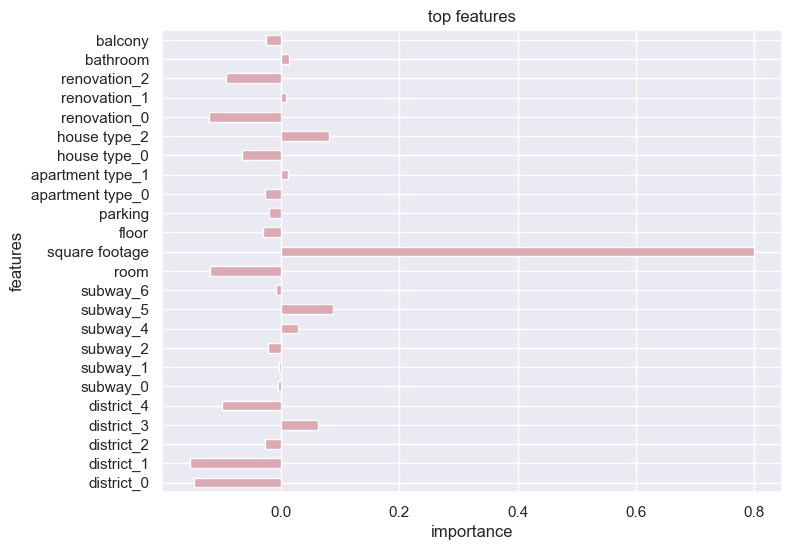

In [87]:
el_df = pd.Series(clf.coef_,index=df_lr.drop('price', axis=1).columns)
el_df = el_df[clf.coef_!=0]
plt.figure(figsize=(8,6))
el_df.plot(kind='barh')
plt.xlabel("importance",fontsize=12)
plt.ylabel("features",fontsize=12)
plt.title("top features",fontsize=12)
plt.show()

Наглядно прослеживается значительное влияние общей площади квартиры на её итоговую стоимость: с увеличением площади увеличивается и цена. Цена растёт и в случае, если квартира расположена в Петроградском районе. На стоимость жилья в незначительной мере влияет близость к метро Чкаловская. Также цена совсем немного растёт с ростом количества ванных комнат и в случае, если дом является монолитным/монолитно-кирпичным.

Удивительно, но с ростом количества комнат стоимость жилья снижается, возможно это обусловлено наличием выбросов (очень высокая стоимость в Петроградском районе даже на жилье с малым числом комнат), хотя и была проведена очистка от них. Также ценник снижает расположение ЖК в определённых районах и отсутствие ремонта.

## Обучение библиотечной модели и построение предсказаний

In [88]:
best_params = grid_search.best_params_
model = ElasticNet(max_iter=10000, **best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## Метрики качества

In [89]:
report_performance(y_test, y_pred, "sklearn ElasticNet report performance")

+---------------------------------------------------------------------------------------------------------+
|                                  sklearn ElasticNet report performance                                  |
+--------------------+---------------------+--------------------+--------------------+--------------------+
|        MSE         |         MAE         |        RMSE        |        MAPE        |         R2         |
+--------------------+---------------------+--------------------+--------------------+--------------------+
| 0.2572928744015344 | 0.28424806472527225 | 0.5072404502812591 | 1.0201881810085818 | 0.7805986577523876 |
+--------------------+---------------------+--------------------+--------------------+--------------------+


## Визуализация

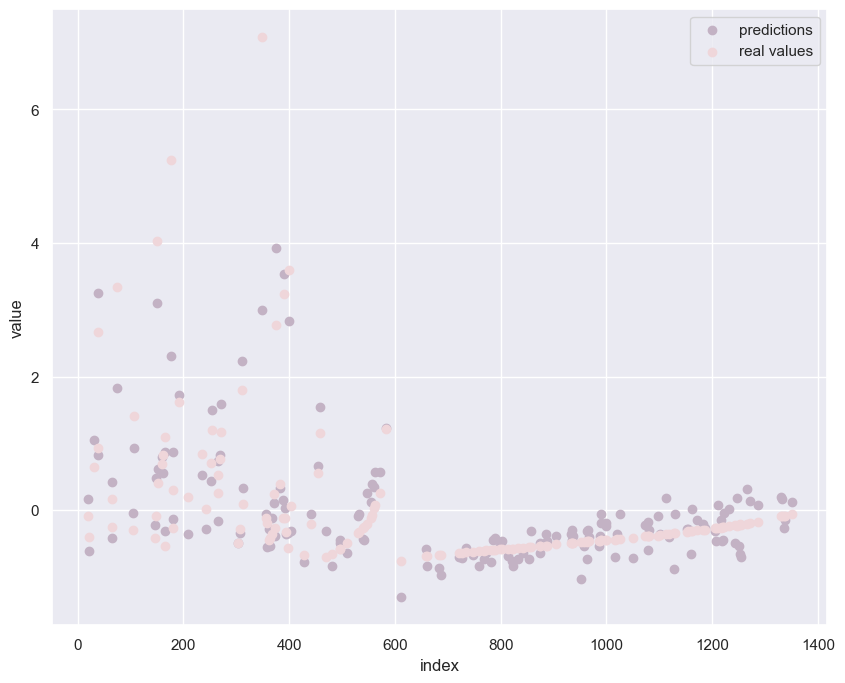

In [90]:
plt.figure(figsize = (10, 8))
plt.scatter(y_test.index, y_pred, color='#c3b2c4', label='predictions')
plt.scatter(y_test.index, y_test, color='#efd6da', label='real values')
plt.xlabel('index')
plt.ylabel('value')

plt.legend()
plt.show()

ошибка на test: 1.0053967626760427


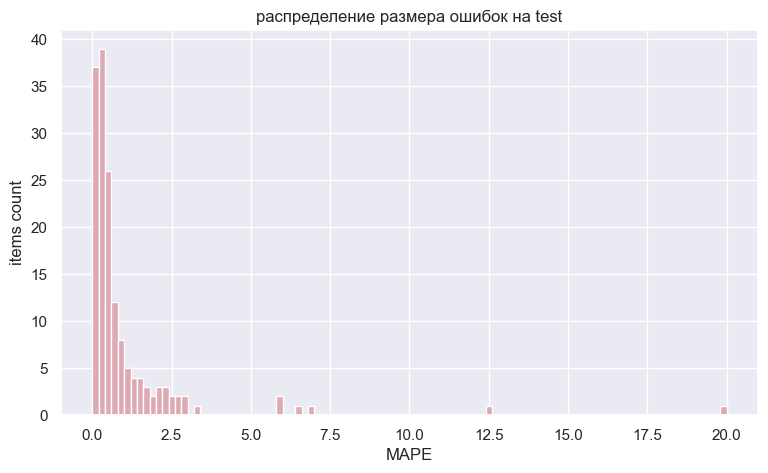

In [91]:
plot_errors(y_pred, y_test, "test")

# Кастомная реализация ElasticNet

In [92]:
class Regularization:
    def __init__(self, alpha = 0.1, l1_ratio = 0.5):
        self.alpha = alpha
        self.l1_ratio = l1_ratio

    def __call__(self, weights: np.ndarray) -> np.ndarray:
        l1_penalty = self.l1_ratio * self.alpha * np.sum(np.abs(weights))
        l2_penalty = (1 - self.l1_ratio) * self.alpha * 0.5 * np.sum(np.square(weights))
        return l1_penalty + l2_penalty

    def derivation(self, weights: np.ndarray) -> np.ndarray:
        l1_derivation = self.alpha * self.l1_ratio * np.sign(weights)
        l2_derivation = self.alpha * (1 - self.l1_ratio) * weights
        return l1_derivation + l2_derivation

In [93]:
class LinearRegression:
    def __init__(self, regularization: Regularization, learning_rate = 0.1, max_iter = 10000):
        self.regularization = regularization
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.n = self.m = self.weights = None

    def gradient_decent(self, x: np.ndarray, y: np.ndarray) -> None:
        for _ in range(self.max_iter):
            predictions = np.dot(x, self.weights)
            dw = (1 / self.m) * np.dot(x.transpose(), (predictions - y)) + self.regularization.derivation(self.weights)
            self.weights -= self.learning_rate * dw

    def fit(self, x: np.ndarray, y: np.ndarray) -> None:
        self.m = x.shape[0]
        self.n = x.shape[1]
        self.weights = np.zeros((self.n, 1))
        self.gradient_decent(x, y)

    def predict(self, x: np.ndarray) -> np.ndarray:
        return np.dot(x, self.weights)

In [94]:
class CustomElasticNet(LinearRegression):
    def __init__(self, alpha = 0.1, l1_ratio = 0.5, learning_rate = 0.1, max_iter = 10000):
        self.regularization = Regularization(alpha, l1_ratio)
        super(CustomElasticNet, self).__init__(self.regularization, learning_rate, max_iter)

    def fit(self, x: np.ndarray, y: np.ndarray) -> None:
        return super(CustomElasticNet, self).fit(x, y)

    def predict(self, x: np.ndarray) -> np.ndarray:
        return super(CustomElasticNet, self).predict(x)

## Обучение кастомной модели и построение предсказаний

In [95]:
model = CustomElasticNet(**best_params)
model.fit(X_train, y_train.values.reshape(y_train.values.shape[0], 1))
y_custom_pred = model.predict(X_test)

# score = r2_score(y_test, y_custom_pred)
# print("The r2_score of the trained model", score)

In [96]:
y_custom_pred = y_custom_pred.reshape(y_test.shape)

## Метрики качества

In [97]:
report_performance(y_test, y_custom_pred, "custom ElasticNet report performance")

+---------------------------------------------------------------------------------------------------------+
|                                   custom ElasticNet report performance                                  |
+---------------------+---------------------+-------------------+--------------------+--------------------+
|         MSE         |         MAE         |        RMSE       |        MAPE        |         R2         |
+---------------------+---------------------+-------------------+--------------------+--------------------+
| 0.25728377682009923 | 0.28487346172748357 | 0.507231482481223 | 1.0225137814977925 | 0.7806064155326321 |
+---------------------+---------------------+-------------------+--------------------+--------------------+


## Визуализация

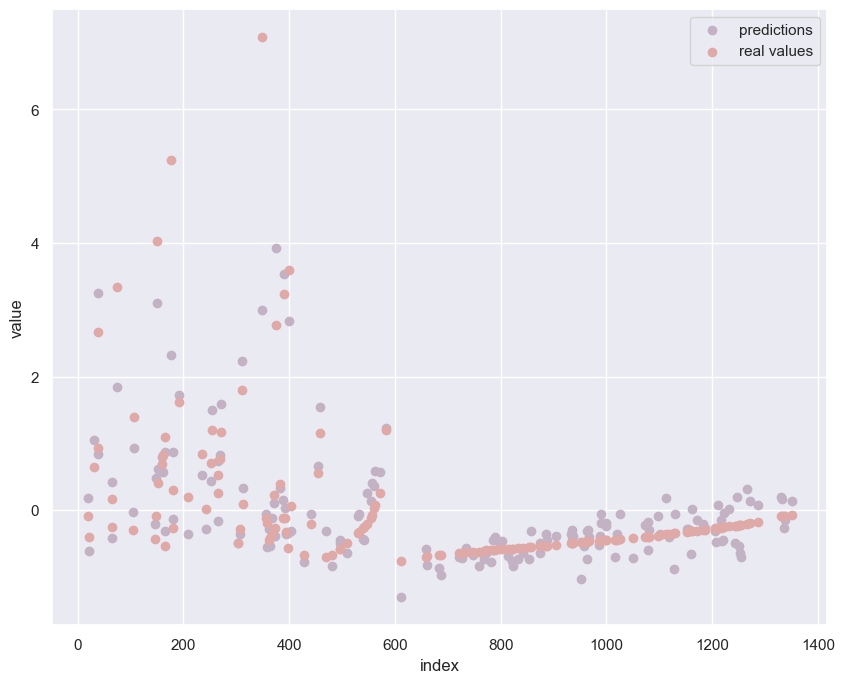

In [98]:
plt.figure(figsize = (10, 8))
plt.scatter(y_test.index, y_custom_pred, color='#c3b2c4', label='predictions')
plt.scatter(y_test.index, y_test, color='#dfa9a8', label='real values')
plt.xlabel('index')
plt.ylabel('value')

plt.legend()
plt.show()

ошибка на test: 1.0090071751832983


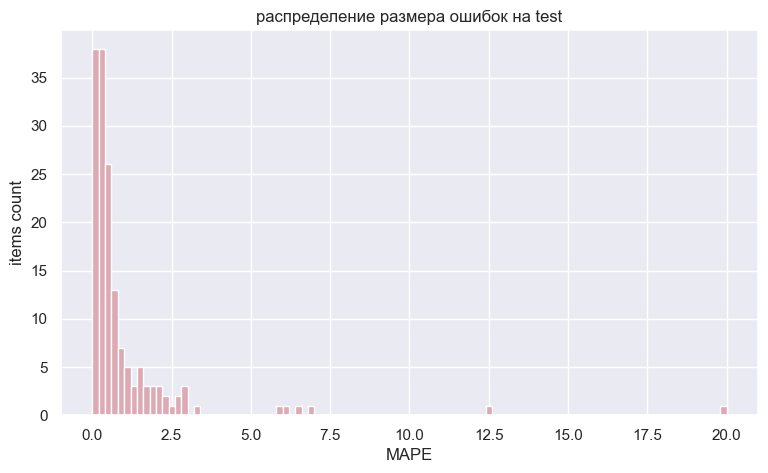

In [99]:
plot_errors(y_custom_pred, y_test, "test")

# Результаты

## Метрики качества

In [100]:
report_performance(y_test, y_pred, "sklearn ElasticNet report performance")

+---------------------------------------------------------------------------------------------------------+
|                                  sklearn ElasticNet report performance                                  |
+--------------------+---------------------+--------------------+--------------------+--------------------+
|        MSE         |         MAE         |        RMSE        |        MAPE        |         R2         |
+--------------------+---------------------+--------------------+--------------------+--------------------+
| 0.2572928744015344 | 0.28424806472527225 | 0.5072404502812591 | 1.0201881810085818 | 0.7805986577523876 |
+--------------------+---------------------+--------------------+--------------------+--------------------+


In [101]:
report_performance(y_test, y_custom_pred, "custom ElasticNet report performance")

+---------------------------------------------------------------------------------------------------------+
|                                   custom ElasticNet report performance                                  |
+---------------------+---------------------+-------------------+--------------------+--------------------+
|         MSE         |         MAE         |        RMSE       |        MAPE        |         R2         |
+---------------------+---------------------+-------------------+--------------------+--------------------+
| 0.25728377682009923 | 0.28487346172748357 | 0.507231482481223 | 1.0225137814977925 | 0.7806064155326321 |
+---------------------+---------------------+-------------------+--------------------+--------------------+


## Визуализация

### Гистограммы распределения размера ошибок

ошибка на test: 1.0053967626760427


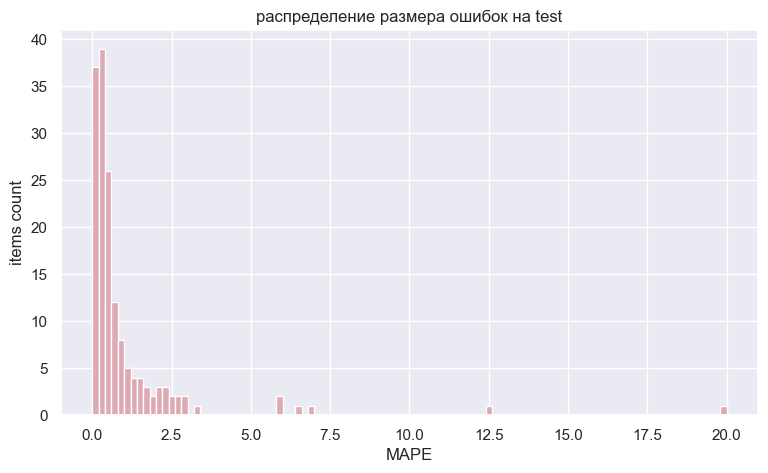

In [102]:
plot_errors(y_pred, y_test, "test")

ошибка на test: 1.0090071751832983


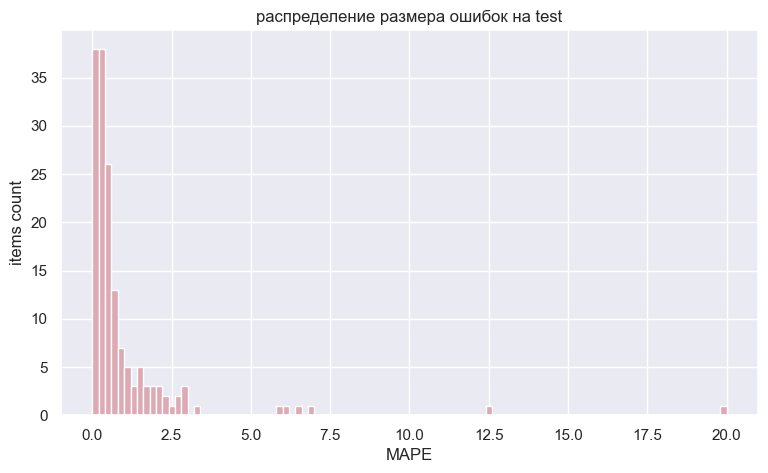

In [103]:
plot_errors(y_custom_pred, y_test, "test")